In [1]:
import geopandas as gpd
import os
import glob

In [2]:
%%time
import xarray as xr
import numpy as np
import skimage.measure
import pandas as pd
from scipy.spatial import distance
import skimage.measure
from skimage.morphology import remove_small_objects,closing,binary_closing
from scipy import ndimage
from datetime import datetime,timedelta
import os
from dask.distributed import Client
import glob
from shapely.geometry import MultiPoint
import geopandas as gpd
import cartopy.crs as ccrs
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature

CPU times: total: 2.72 s
Wall time: 3.13 s


In [3]:
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from matplotlib import cm

In [4]:
from CPF import *
from grizzly import *
from coagmet import *
from disdrometer import *
from mrms_gage import *
from usgs_other import *
from elevation import *

from mrms_gage import *

create fig of study area
create timeseries compare for accum and 15min with stats

create figs of intensity duration in basins
create plot of gage vs mrms time series with threshold

In [5]:
# Create a path to the code file
codeDir = os.path.dirname(os.path.abspath(os.getcwd()))
parentDir = os.path.dirname(codeDir)

In [6]:
# open basins
deb_folder = os.path.join(parentDir,"sedhyd_shapefiles")
cpf_basins=gpd.read_file(deb_folder+'\\cpf_basins.shp')
grizzly_basins=gpd.read_file(deb_folder+'\\grizzly_basins.shp')

In [7]:
# open gages
gage_folder = os.path.join(parentDir,"precip_gage")

# grizzly
grizzly = get_grizzly(gage_folder)
# cpf
cpf = get_cpf(gage_folder+'\\cpf google drive')
# only select dry and washout

# disdrometer
disdrom = get_disdrom(gage_folder)


Z:\working code\mrms_eval\grizzly.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gage = [gage[i].drop(gage[i].columns.difference(['TimeStamp (Local)','15-minute Intensity (mm/h)','Bin Accum (mm)']), 1) for i in range(len(gage_id))]


In [8]:
dry = cpf[(40.70672394,254.36060709999998)]
dry.index = dry.index+np.timedelta64(1, 'h')

In [9]:
# add washout
# location came from looking at map on this stormymap https://storymaps.arcgis.com/stories/af3cd28cad6040e9a3a3d608f58292a7
lat_washout=40.699756
lon_washout=-105.67277+360
name = 'washout'

washout=pd.read_csv(parentDir+"\\washout_gulch_072021.csv")
washout=washout[['Time','i15 [mm/h]','accum']]
washout['Time']=[pd.Timestamp(washout['Time'][i][0:16]) for i in washout.index]
washout = washout.set_index(['Time'])
washout.loc[washout['accum']<0] = 0
washout = washout.rename(columns={'i15 [mm/h]':'15_int'})

In [10]:
coord = [i for i in grizzly.keys()]

In [11]:
# names
# get names
coord = [i for i in grizzly.keys()]
grizzly_id=['GCFC2','GCEC2','GCNC2','GCTC2','GCCC2','GCDC2']

grizzly_names={grizzly_id[i]:'Gage ID: '+grizzly_id[i]+', Coordinates: '+str(round(coord[i][0],2))+', '+str(round(coord[i][1]-360,
                                                                                               2)) for i in range(len(grizzly_id))}

dry = cpf[(40.70672394,254.36060709999998)]

dry_names = {'dry':'Gage ID: '+'Dry'+', Coordinates: '+str(round(40.70672394,2))+', '+str(round(254.36060709999998-360,2))}

disdrom_names = {'disdrom':'Gage ID: '+'Dry (disdrometer)'+', Coordinates: '+str(round(40.70672394,2))+', '+str(round(254.36060709999998-360,2))}

washout_names = {'washout':'Gage ID: '+'Washout'+', Coordinates: '+str(round(lat_washout,2))+', '+str(round(lon_washout-360,2))}

gage_names = {**grizzly_names, **dry_names, **disdrom_names, **washout_names}

In [12]:
# coordinates
grizzly_coord={grizzly_id[i]:coord[i] for i in range(len(grizzly_id))}
dry_coord = {'dry':(40.70672394,254.36060709999998)}
disdrom_coord = {'disdrom':(40.70672394,254.36060709999998)}
washout_coord = {'washout':(lat_washout,lon_washout)}

gage_coord = {**grizzly_coord , **dry_coord , **disdrom_coord , **washout_coord }

In [13]:
# values
grizzly_v={grizzly_id[i]:grizzly[coord[i]]['2021-07-29':'2021-07-31'] for i in range(6)}
dry_v = {'dry':dry['2021-07-20':'2021-07-21']}
#disdrom_v = {'disdrom':disdrom[(40.706724,254.360607)]['2021-07-20':'2021-07-21']}
disdrom_v = {'disdrom':disdrom[(40.706724,254.360607)]}
washout_v = {'washout':washout['2021-07-20':'2021-07-21']}

gage_values = {**grizzly_v, **dry_v , **disdrom_v , **washout_v}

In [14]:
# open multisensor corrected rate
# see mrms_atgage.py for how this dataset was built
# 2 min ACCUMULATION for months may thru sep, 2021/2022, in MST
jul21 = xr.open_dataset(parentDir+'\\MRMS\\2min_rate_cat_month_CO\\\eval\\jul_2021_rate_CO.grib2',chunks={'time': '50MB'})
aug21 = xr.open_dataset(parentDir+'\\MRMS\\2min_rate_cat_month_CO\\\eval\\aug_2021_rate_CO.grib2',chunks={'time': '50MB'})

Ignoring index file 'Z:\\\\MRMS\\2min_rate_cat_month_CO\\\\eval\\jul_2021_rate_CO.grib2.923a8.idx' incompatible with GRIB file
Can't read index file 'Z:\\\\MRMS\\2min_rate_cat_month_CO\\\\eval\\aug_2021_rate_CO.grib2.923a8.idx'
Traceback (most recent call last):
  File "C:\Users\whitep\.conda\envs\radar\lib\site-packages\cfgrib\messages.py", line 541, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
  File "C:\Users\whitep\.conda\envs\radar\lib\site-packages\cfgrib\messages.py", line 423, in from_indexpath
    index = pickle.load(file)
EOFError: Ran out of input


In [15]:
mrms_rate = xr.concat([jul21,aug21],dim='time')

In [16]:
# open multisensor qpe for 2021,2022
mrms_multi_folder = os.path.join(parentDir,"MRMS","1hr_QPE_multi_cat_yr_CO")
mrms_multi_21 = xr.open_dataset(mrms_multi_folder+'\\2021_multiQPE_CO.grib2',chunks={'time': '50MB'})

# open radaronly qpe for 2021,2022
mrms_radar_folder = os.path.join(parentDir,"MRMS","1hr_QPE_radar_cat_yr_CO")
mrms_radar_21 = xr.open_dataset(mrms_radar_folder+'\\2021_radarQPE_CO.grib2',chunks={'time': '50MB'})

# divide multisesor by radar-only, fill Nan with 1
correction_21 = (mrms_multi_21/mrms_radar_21).fillna(1)
# resample 1-hour to 2-min to apply to 2-min accumulation
correction_21 = correction_21.resample(time='2min').pad()
# fill inf with 1
correction_21 = correction_21.where(correction_21.unknown != np.inf).fillna(1)


C:\Users\whitep\.conda\envs\radar\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
mrms_accum = mrms_rate*(2/60)
mrms_2_corrected = mrms_accum*correction_21

# change time to MST
mrms_2_corrected = time_change(mrms_2_corrected)
mrms_multi_21 = time_change(mrms_multi_21)

C:\Users\whitep\.conda\envs\radar\lib\site-packages\xarray\core\indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [19]:
# open RQI
mrms_RQI_folder = os.path.join(parentDir,"MRMS","RQI_cat_yr_CO")
RQI_21 = xr.open_dataset(mrms_RQI_folder+'\\2021_RQI_CO.grib2',chunks={'time': '50MB'})
# time change
RQI_21 = time_change(RQI_21)

# select cpf 
gage_id = ['dry','disdrom','washout']

values = gage_values[gage_id[0]]['2021-07-20 16:00':'2021-07-20 20:00']
RQI_cpf = RQI_21.sel(latitude = slice(40.63, 40.72), longitude = slice(254.27, 254.38))
RQI_cpf = RQI_cpf.sel(time = slice(values.index[0], values.index[-1]))

# select grizzly 1

gage_id = ['GCFC2','GCEC2','GCNC2','GCTC2','GCCC2','GCDC2']

RQI_21_griz_1 =RQI_21.sel(latitude = slice(39.53, 39.665), longitude = slice(252.685, 252.885))
values = gage_values[gage_id[0]]['2021-07-29 18:00':'2021-07-29 23:00']
RQI_21_griz_1 = RQI_21_griz_1.sel(time = slice(values.index[0], values.index[-1]))

# select grizzly 2
RQI_21_griz_2 = RQI_21.sel(latitude = slice(39.53, 39.665), longitude = slice(252.685, 252.885))
values = gage_values[gage_id[0]]['2021-07-31 15:00':'2021-07-31 20:00']
RQI_21_griz_2 = RQI_21_griz_2.sel(time = slice(values.index[0], values.index[-1]))


Ignoring index file 'Z:\\MRMS\\RQI_cat_yr_CO\\2021_RQI_CO.grib2.923a8.idx' incompatible with GRIB file


In [20]:
RQI_cpf.unknown.mean().compute()

<xarray.DataArray 'unknown' ()>
array(0.8999999, dtype=float32)
Coordinates:
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0

In [21]:
RQI_21_griz_1.unknown.mean().compute()

<xarray.DataArray 'unknown' ()>
array(0.84607136, dtype=float32)
Coordinates:
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0

In [22]:
RQI_21_griz_2.unknown.mean().compute()

<xarray.DataArray 'unknown' ()>
array(0.81785715, dtype=float32)
Coordinates:
    step            timedelta64[ns] 00:00:00
    heightAboveSea  float64 0.0

grizzly

In [23]:
gage_id = ['GCFC2','GCEC2','GCNC2','GCTC2','GCCC2','GCDC2']

In [474]:
#values = gage_values[gage_id[0]]

In [27]:
gage_values[gage_id[5]].max()

accum      2.370667
15_int    67.056000
dtype: float64

In [476]:
#values.loc[values['15_int']<10] = 0

c:\temp\3\ipykernel_11216\3285400275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values.loc[values['15_int']<10] = 0


C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

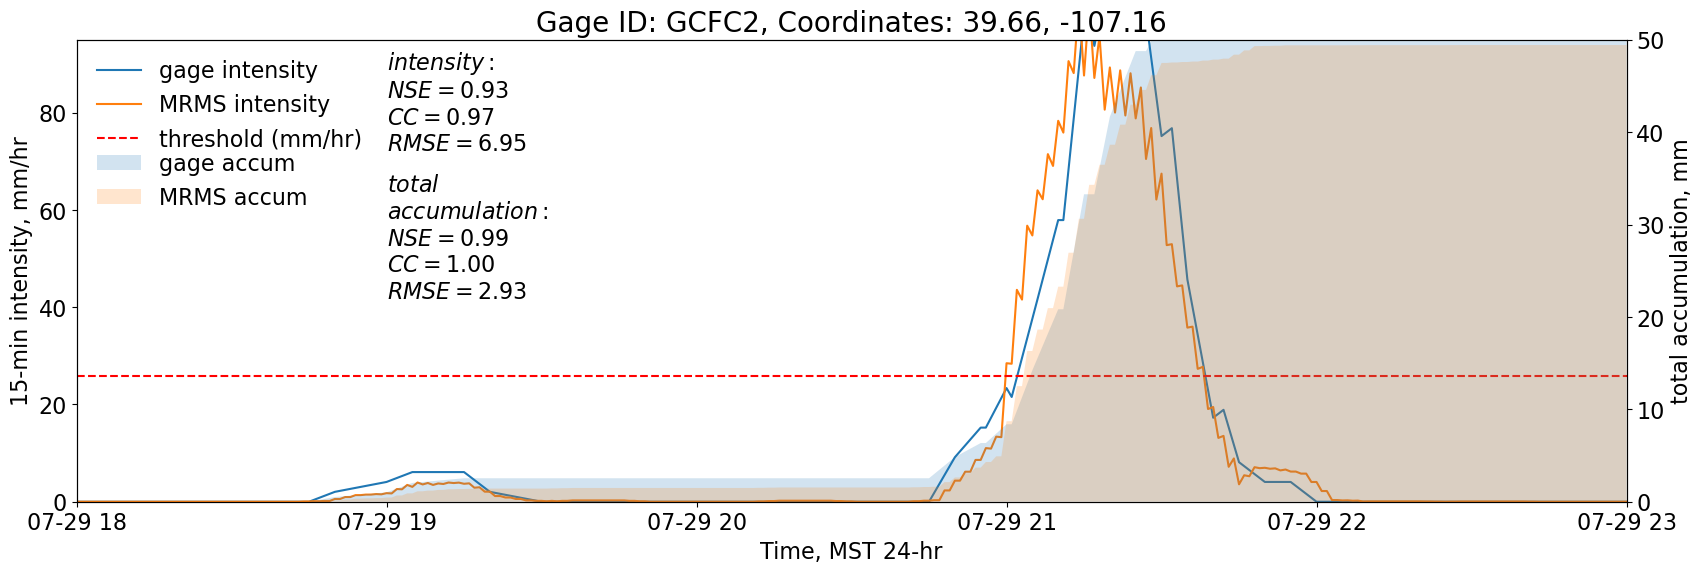

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

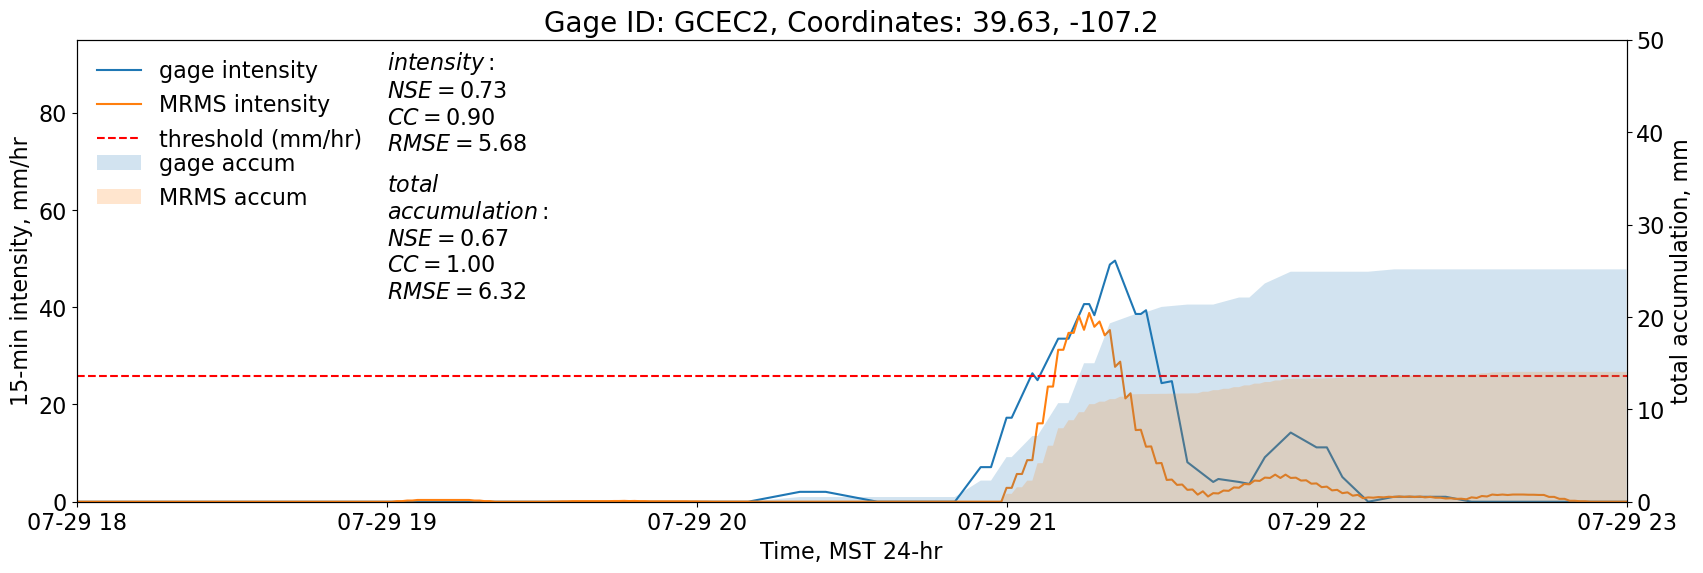

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered

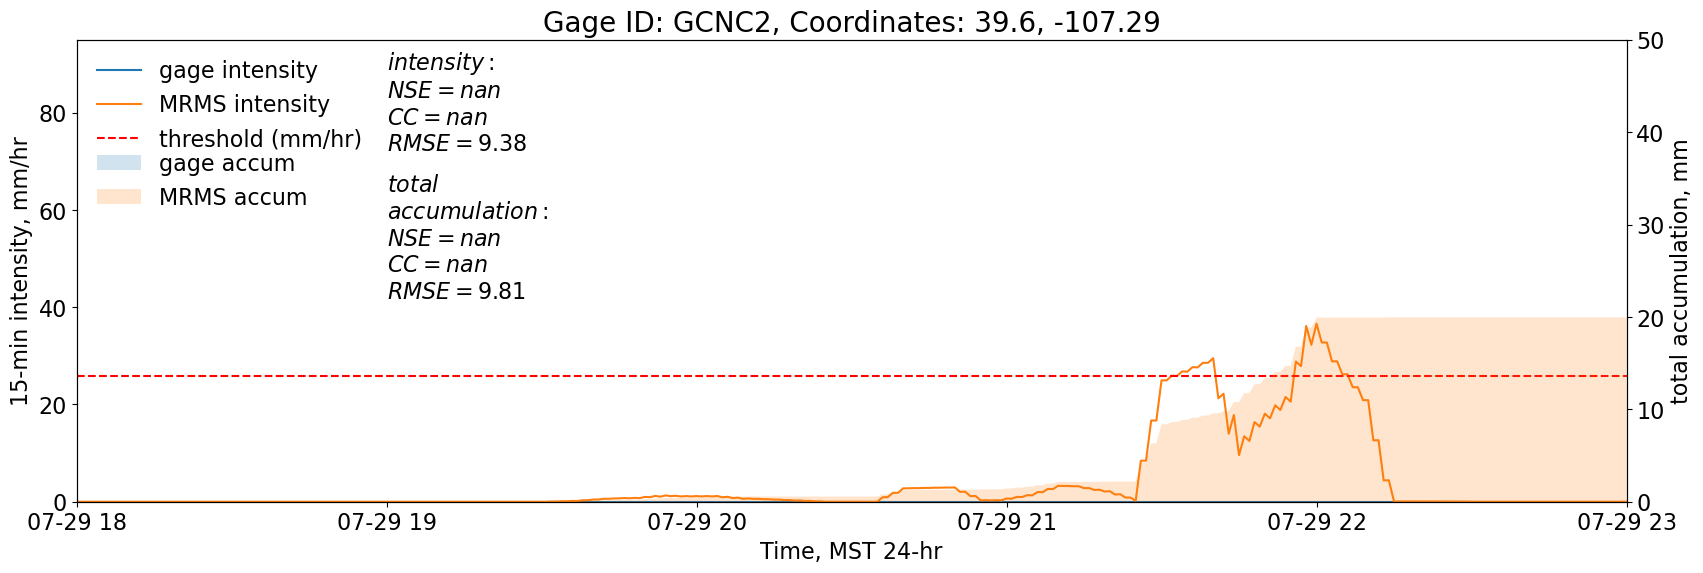

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered

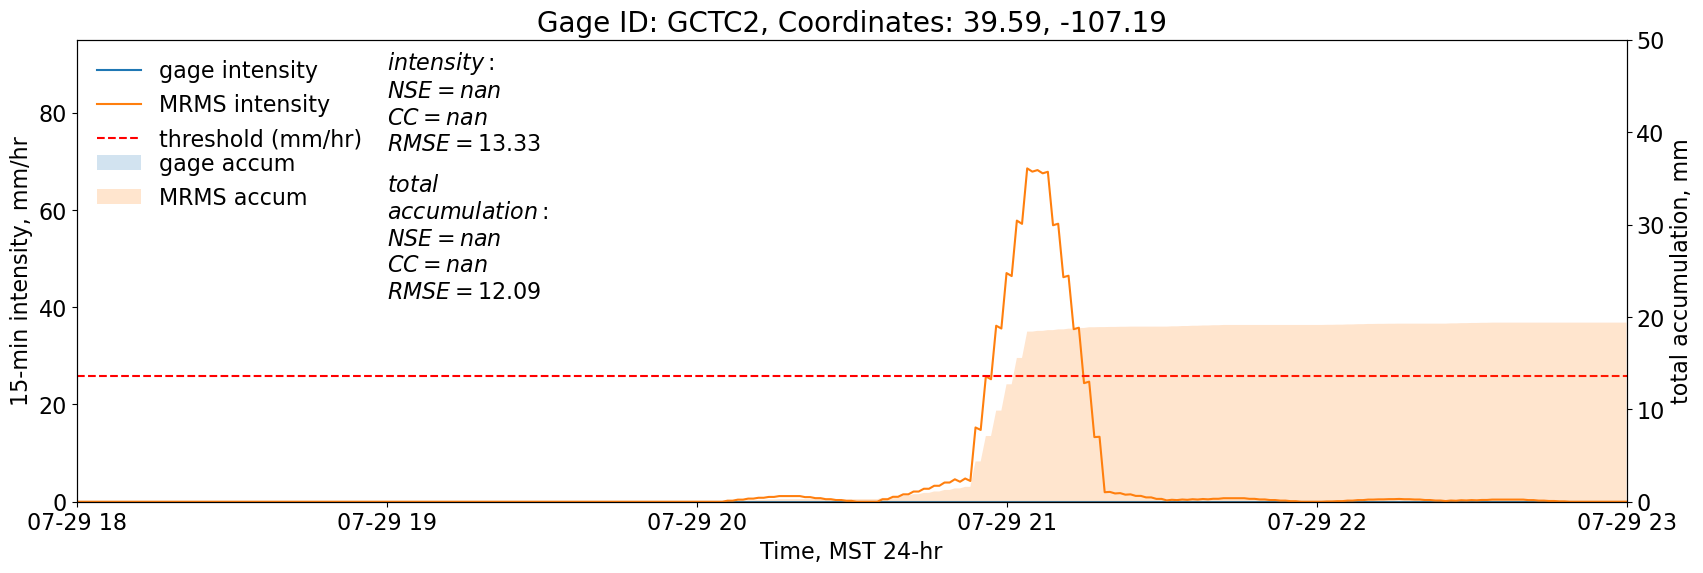

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

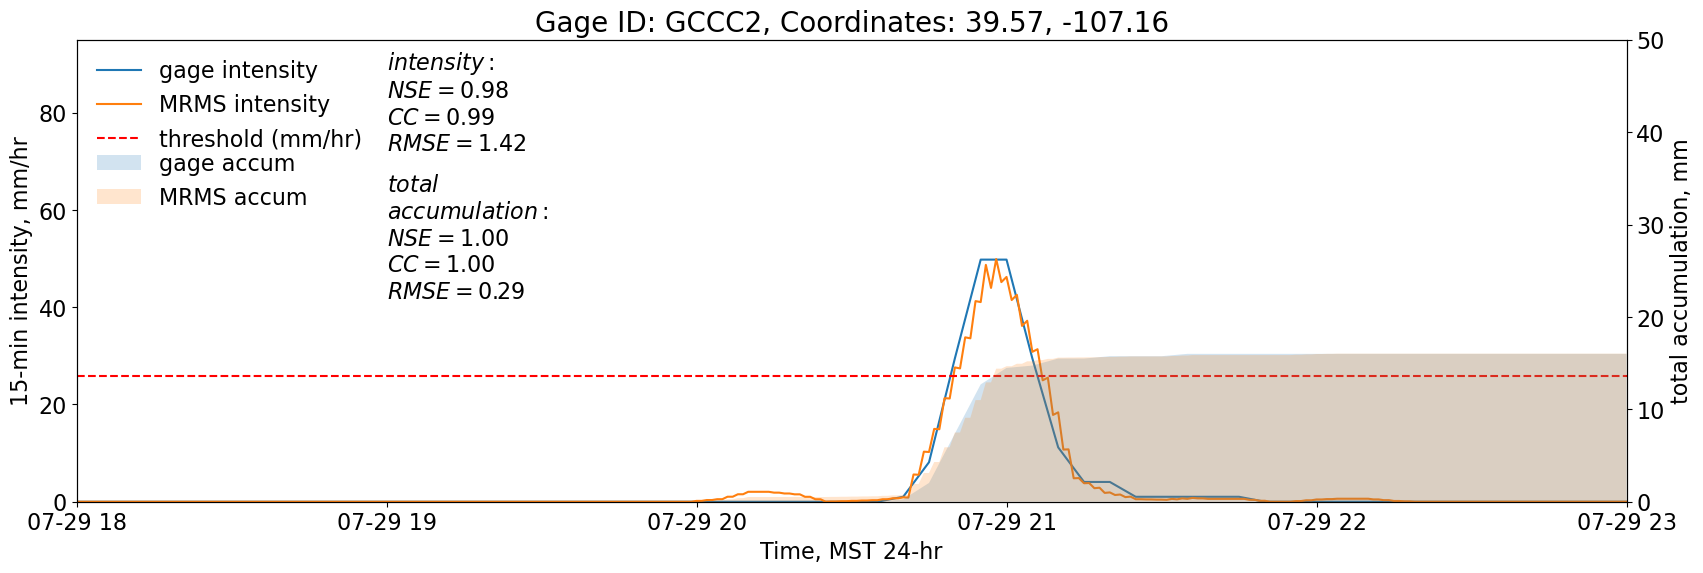

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

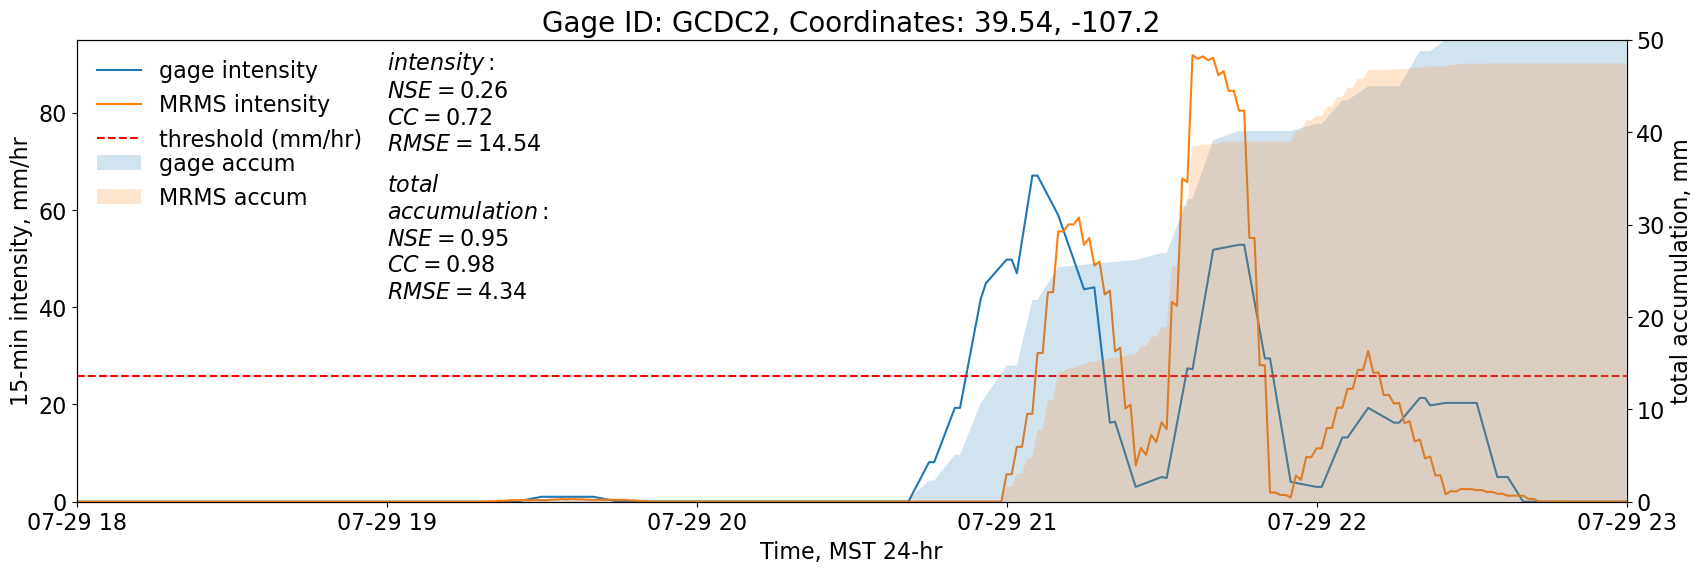

In [30]:
for i in range(len(gage_id)):
    coord = gage_coord[gage_id[i]]
    values = gage_values[gage_id[i]]['2021-07-29 18:00':'2021-07-29 23:00']
    name = gage_names[gage_id[i]]
    
    m_accum = mrms_2_corrected.sel(time = slice(values.index[0], values.index[-1]))
    m_accum = m_accum.sel(latitude = coord[0], longitude = coord[1], method='nearest')
    
    m_accum = m_accum.resample(time='1min').asfreq()
    m_accum = m_accum.unknown.fillna(0)
    m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)
    
    fig, ax1 = plt.subplots(1, figsize=(20,6))
    plt.xticks(fontsize=14)     
    ax1.tick_params(labelsize = 16)   

    ax2 = ax1.twinx()
    ax2.tick_params(labelsize = 16)
    ax1.plot(values.index,values['15_int'])
    ax1.plot(m_15.time,m_15)

    ax2.fill_between(values.index,values['accum'].cumsum(),alpha=.2)
    ax2.fill_between(m_accum.time,m_accum.cumsum(),alpha=.2)    

    threshold = 25.9
    x1 = values.index[0]
    x2 = values.index[-1]

    ax1.plot([x1,x2],[threshold,threshold],'r--')

    ax1.set_ylabel('15-min intensity, mm/hr',fontsize=16)
    ax2.set_ylabel('total accumulation, mm',fontsize=16)
    ax1.set_xlabel('Time, MST 24-hr',fontsize=16)

    plt.xlim(x1,x2)
    ax1.set_ylim(bottom=0,top=95)
    ax2.set_ylim(bottom=0,top=50)
    

    prediction = m_15.values
    target = values['15_int'].values
    nash1=nse(prediction,target)
    CC1=np.corrcoef(prediction,target)[0,1]
    rmse1 = np.sqrt(np.mean((prediction-target)**2))

    prediction2 = m_accum.cumsum().values
    target2 = values['accum'].cumsum().values
    nash2=nse(prediction2,target2)
    CC2=np.corrcoef(prediction2,target2)[0,1]
    rmse2 = np.sqrt(np.mean((prediction2-target2)**2))

    textstr1 = '\n'.join((
    r'$intensity:%.2f$' ,
    r'$NSE=%.2f$' % (nash1, ),
    r'$CC=%.2f$' % (CC1, ),
    r'$RMSE=%.2f$' % (rmse1, ),))

    textstr2 = '\n'.join((
    r'$total%.2f$' ,
    r'$accumulation:%.2f$' ,
    r'$NSE=%.2f$' % (nash2, ),
    r'$CC=%.2f$' % (CC2, ),
    r'$RMSE=%.2f$' % (rmse2, ),))

    #props = dict(boxstyle='round', alpha=0.5)
    plt.text(0.2, .98, textstr1, transform=ax1.transAxes,fontsize=16,verticalalignment='top')
    plt.text(0.2, .71, textstr2, transform=ax1.transAxes,fontsize=16,verticalalignment='top')

    ax1.legend(['gage intensity','MRMS intensity','threshold (mm/hr)'],fontsize=16,frameon=False,loc='upper left')
    ax2.legend(['gage accum','MRMS accum'],fontsize=16,frameon=False,loc='upper left', bbox_to_anchor=(0, 0.80))

    plt.title(name,fontsize=20)
    plt.show()

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

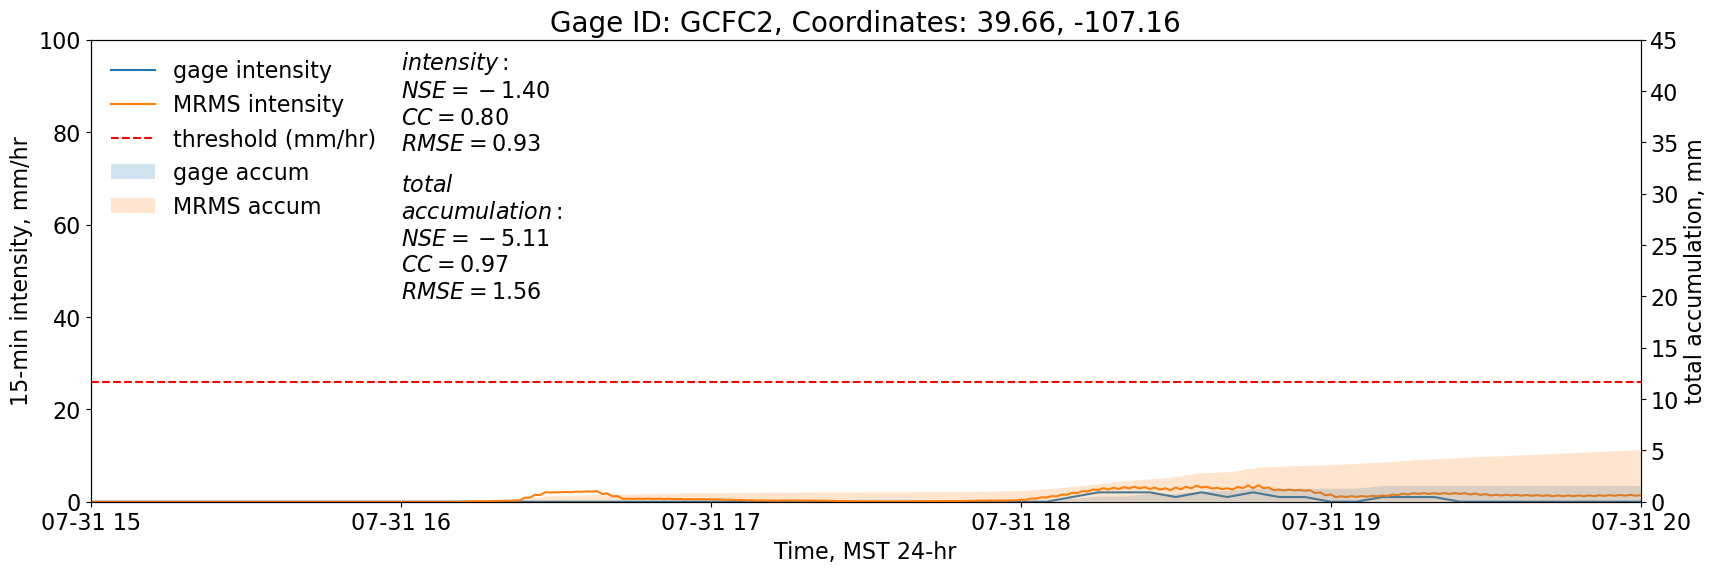

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

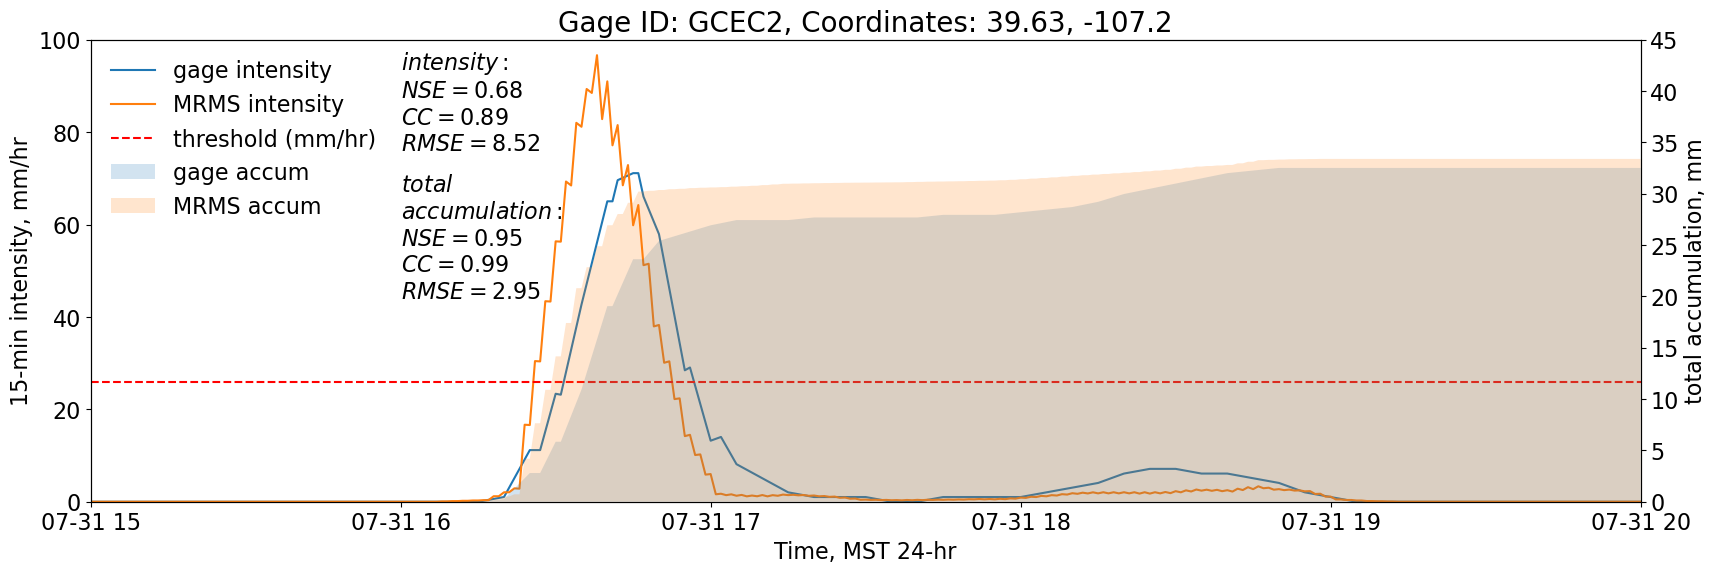

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered

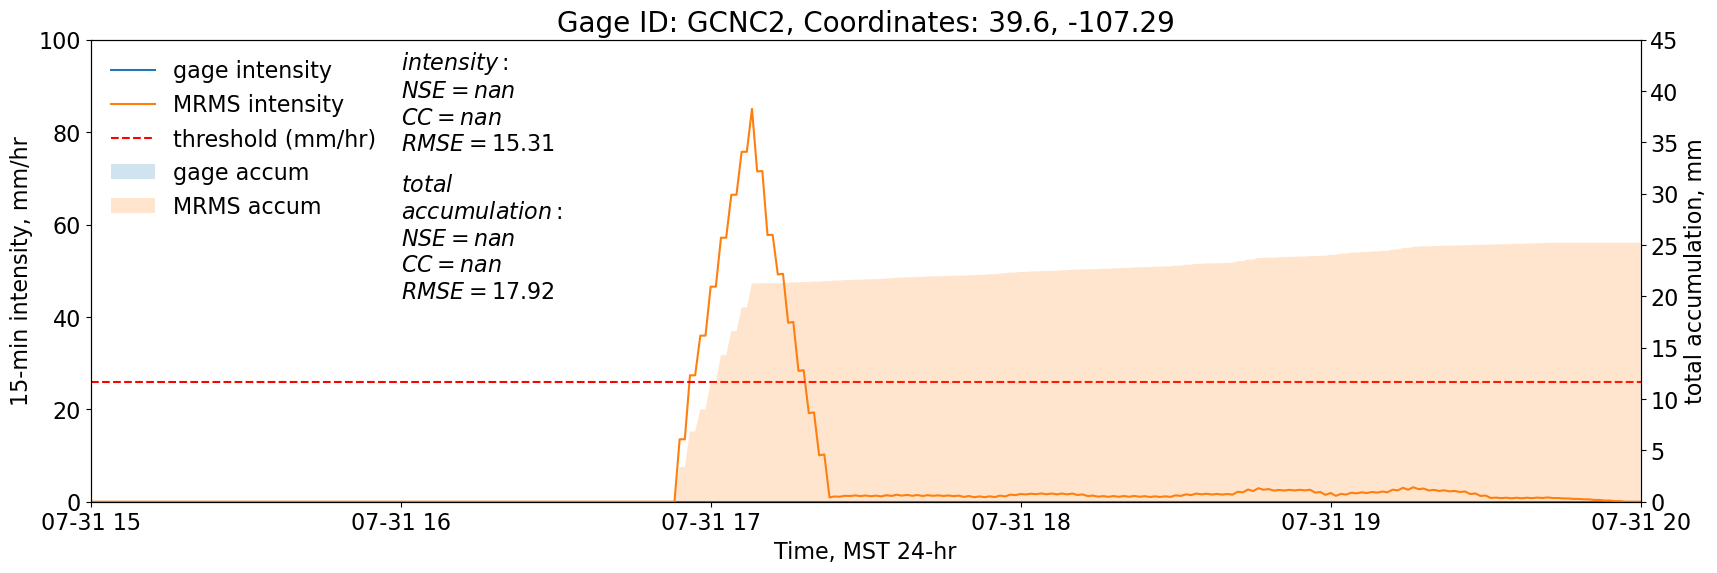

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\whitep\.conda\envs\radar\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered

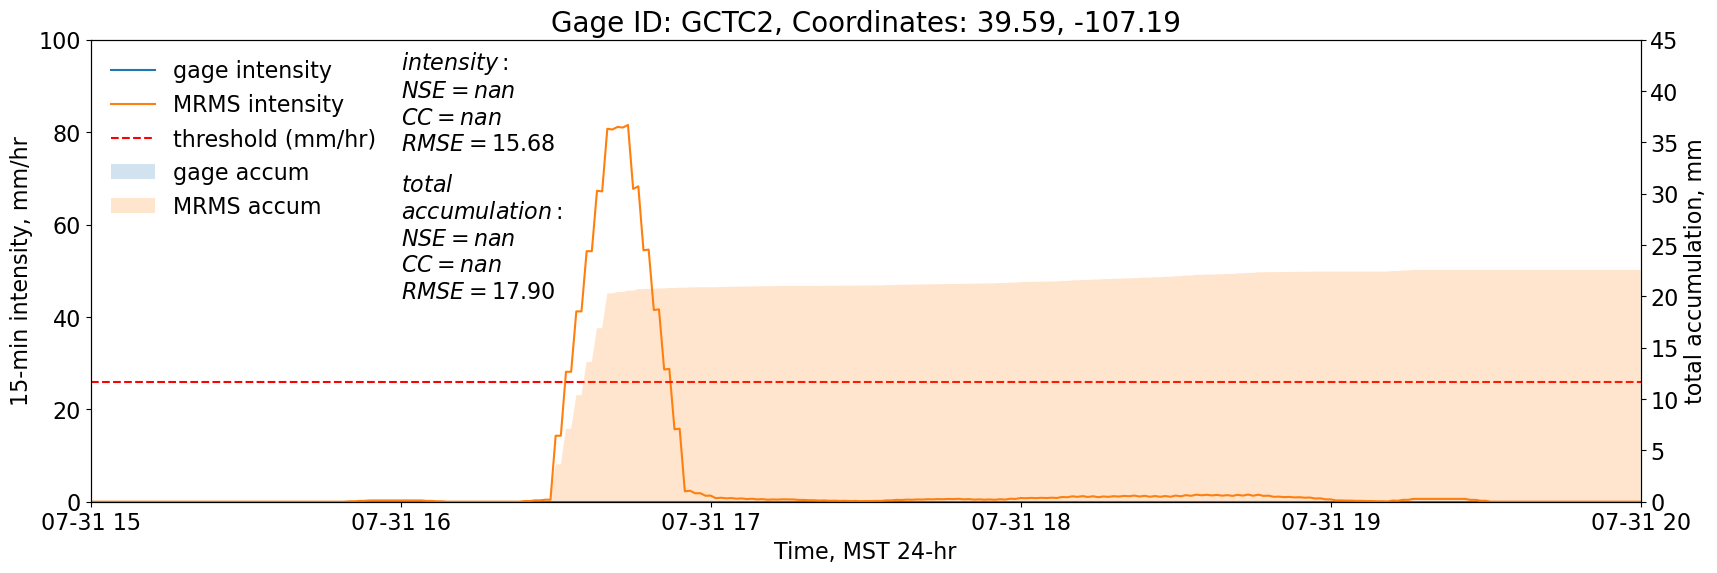

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

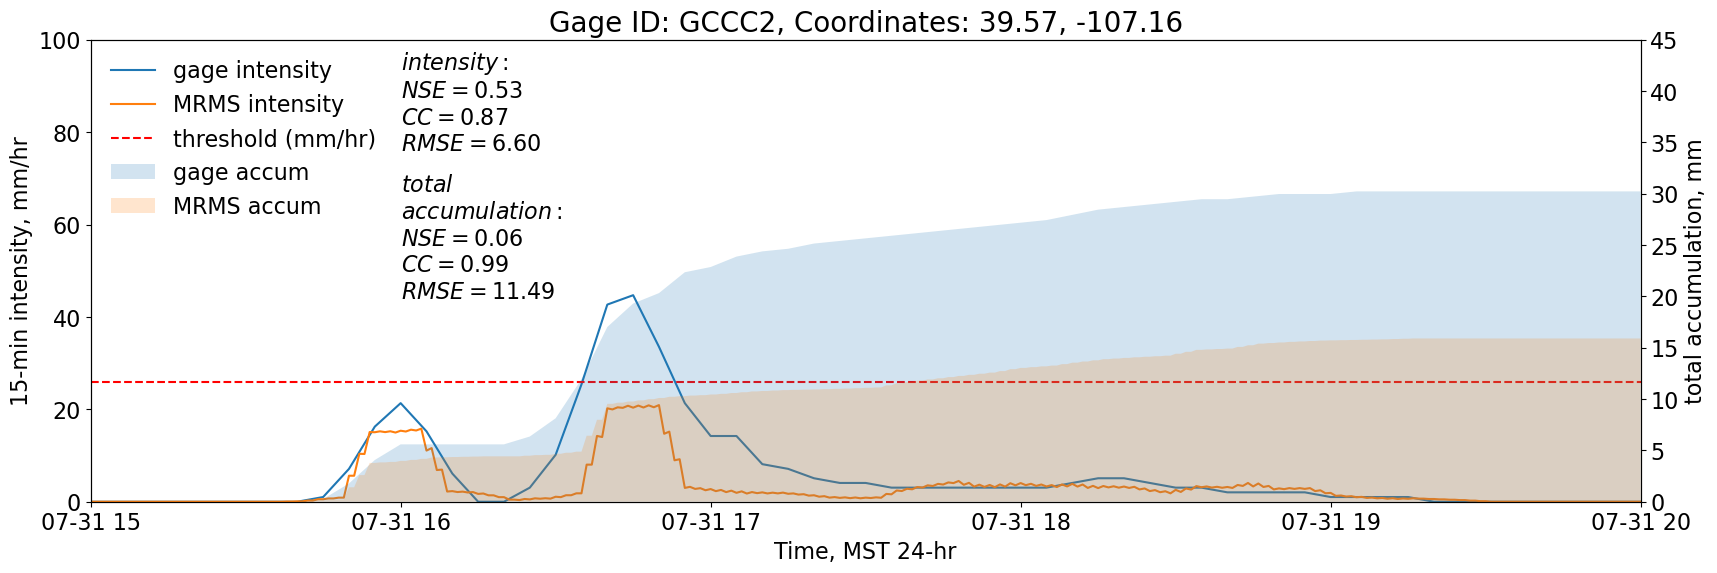

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

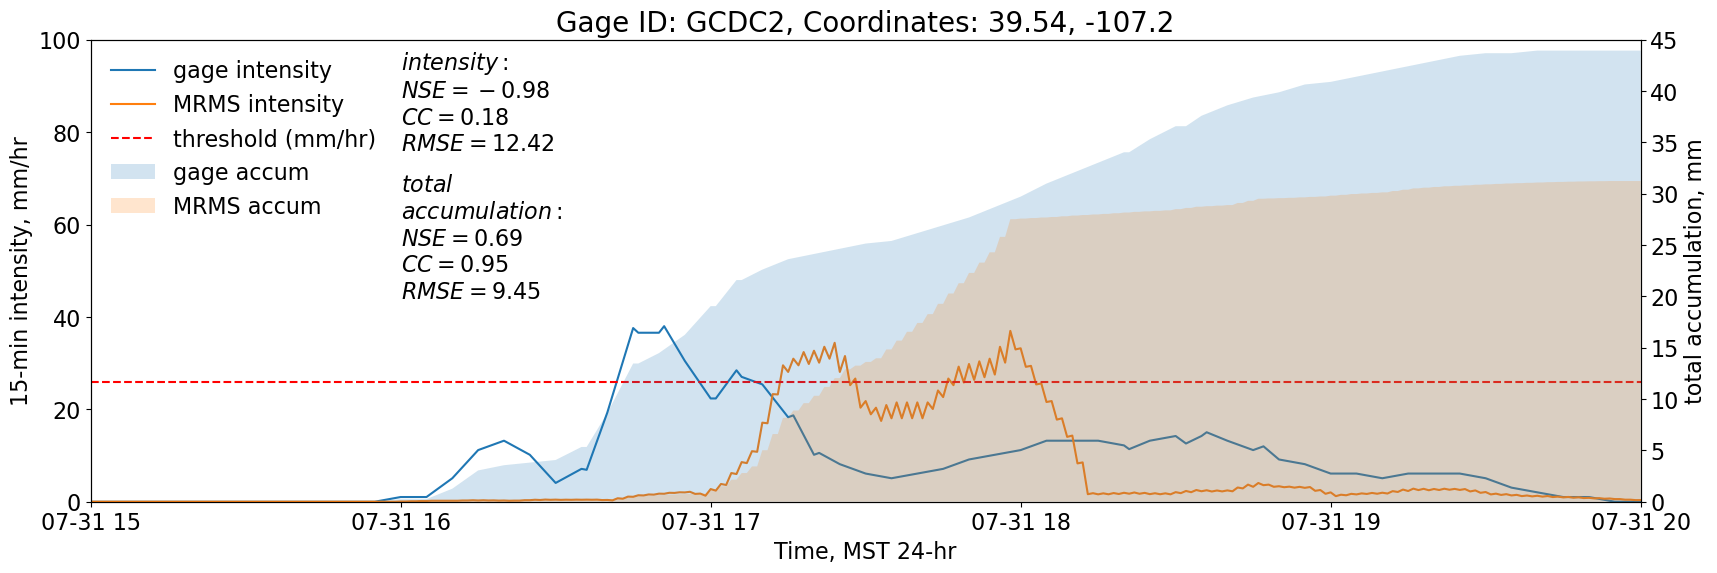

In [31]:
for i in range(len(gage_id)):
    coord = gage_coord[gage_id[i]]
    values = gage_values[gage_id[i]]['2021-07-31 15:00':'2021-07-31 20:00']
    name = gage_names[gage_id[i]]
    
    m_accum = mrms_2_corrected.sel(time = slice(values.index[0], values.index[-1]))
    m_accum = m_accum.sel(latitude = coord[0], longitude = coord[1], method='nearest')
    
    m_accum = m_accum.resample(time='1min').asfreq()
    m_accum = m_accum.unknown.fillna(0)
    m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)
    
    fig, ax1 = plt.subplots(1, figsize=(20,6))
    plt.xticks(fontsize=16)     
    ax1.tick_params(labelsize = 16)   

    ax2 = ax1.twinx()
    ax2.tick_params(labelsize = 16)
    ax1.plot(values.index,values['15_int'])
    ax1.plot(m_15.time,m_15)

    ax2.fill_between(values.index,values['accum'].cumsum(),alpha=.2)
    ax2.fill_between(m_accum.time,m_accum.cumsum(),alpha=.2)    

    threshold = 25.9
    x1 = values.index[0]
    x2 = values.index[-1]

    ax1.plot([x1,x2],[threshold,threshold],'r--')

    ax1.set_ylabel('15-min intensity, mm/hr',fontsize=16)
    ax2.set_ylabel('total accumulation, mm',fontsize=16)
    ax1.set_xlabel('Time, MST 24-hr',fontsize=16)

    plt.xlim(x1,x2)
    ax1.set_ylim(bottom=0,top=100)
    ax2.set_ylim(bottom=0,top=45)

    prediction = m_15.values
    target = values['15_int'].values
    nash1=nse(prediction,target)
    CC1=np.corrcoef(prediction,target)[0,1]
    rmse1 = np.sqrt(np.mean((prediction-target)**2))

    prediction2 = m_accum.cumsum().values
    target2 = values['accum'].cumsum().values
    nash2=nse(prediction2,target2)
    CC2=np.corrcoef(prediction2,target2)[0,1]
    rmse2 = np.sqrt(np.mean((prediction2-target2)**2))

    textstr1 = '\n'.join((
    r'$intensity:%.2f$' ,
    r'$NSE=%.2f$' % (nash1, ),
    r'$CC=%.2f$' % (CC1, ),
    r'$RMSE=%.2f$' % (rmse1, ),))

    textstr2 = '\n'.join((
    r'$total%.2f$' ,
    r'$accumulation:%.2f$' ,
    r'$NSE=%.2f$' % (nash2, ),
    r'$CC=%.2f$' % (CC2, ),
    r'$RMSE=%.2f$' % (rmse2, ),))

    #props = dict(boxstyle='round', alpha=0.5)
    plt.text(0.2, .98, textstr1, transform=ax1.transAxes,fontsize=16,verticalalignment='top')
    plt.text(0.2, .71, textstr2, transform=ax1.transAxes,fontsize=16,verticalalignment='top')

    ax1.legend(['gage intensity','MRMS intensity','threshold (mm/hr)'],fontsize=16,frameon=False,loc='upper left')
    ax2.legend(['gage accum','MRMS accum'],fontsize=16,frameon=False,loc='upper left', bbox_to_anchor=(0, 0.78))

    plt.title(name,fontsize=20)
    plt.show()

cameron peak

In [32]:
gage_id = ['dry','disdrom','washout']

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

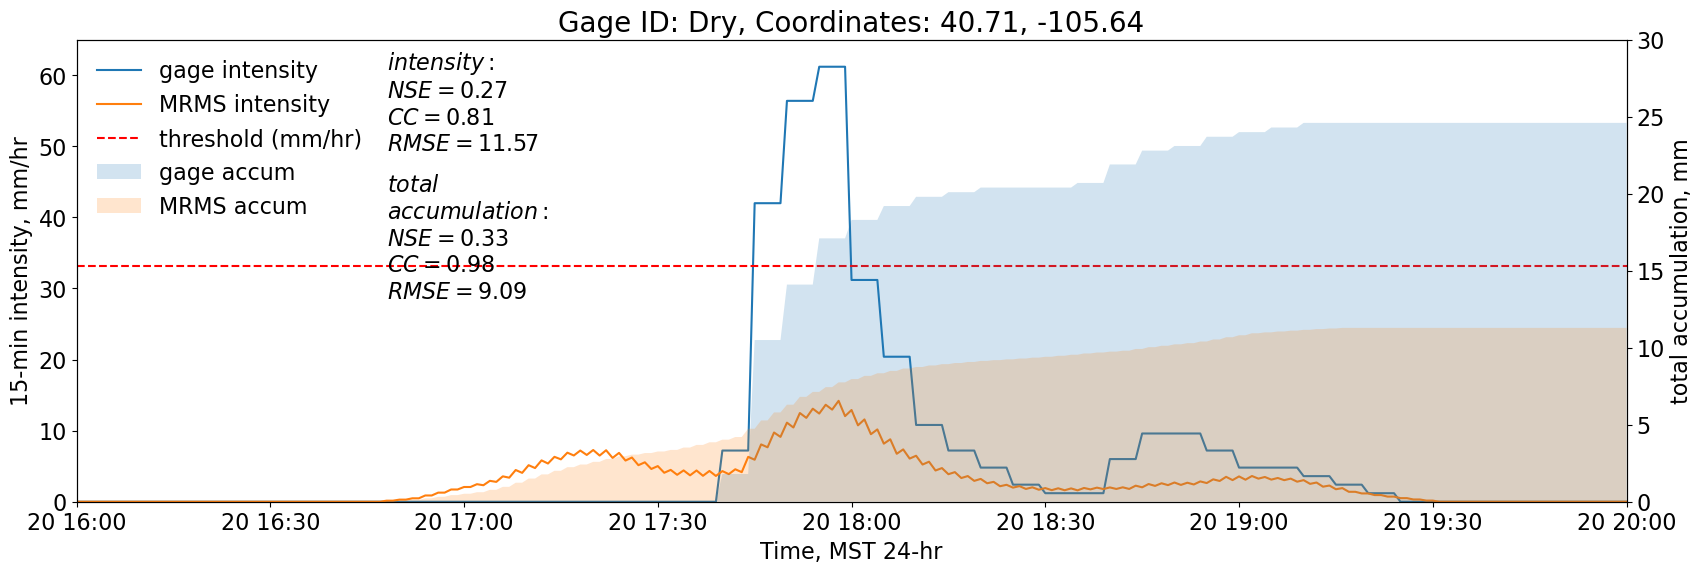

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

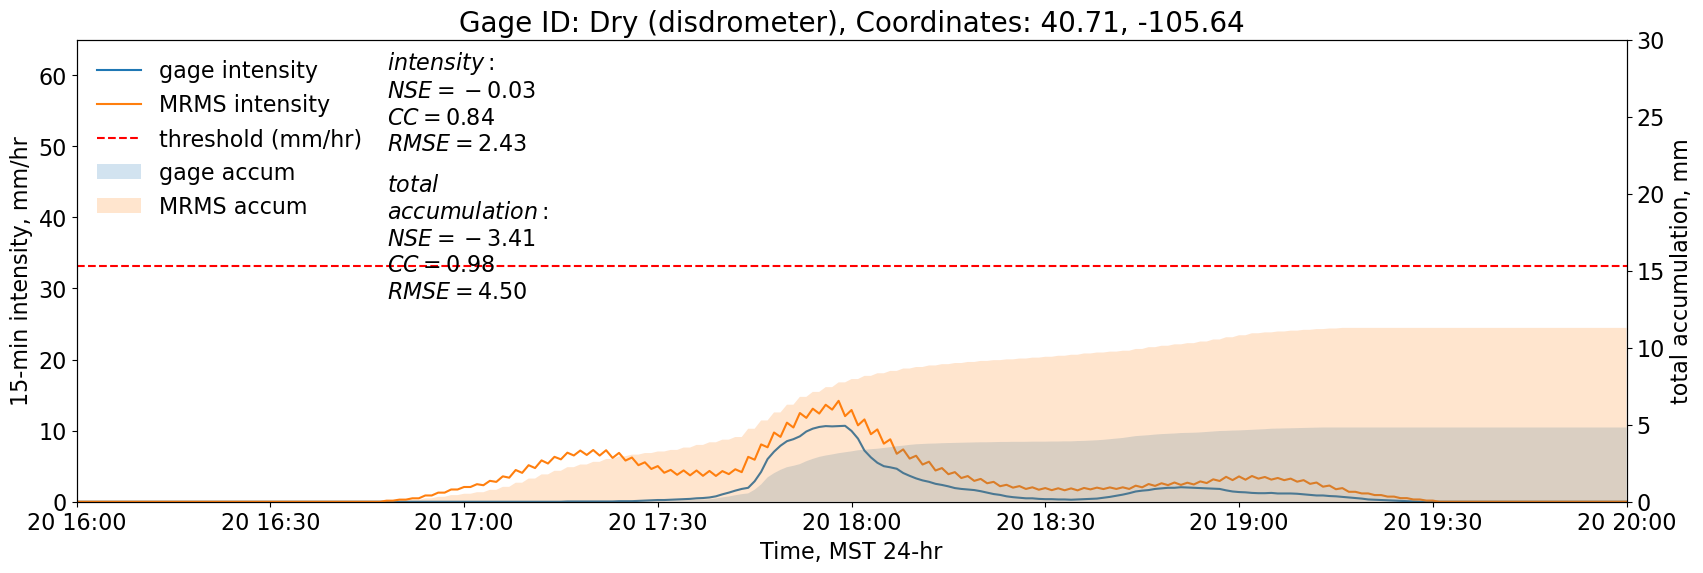

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encount

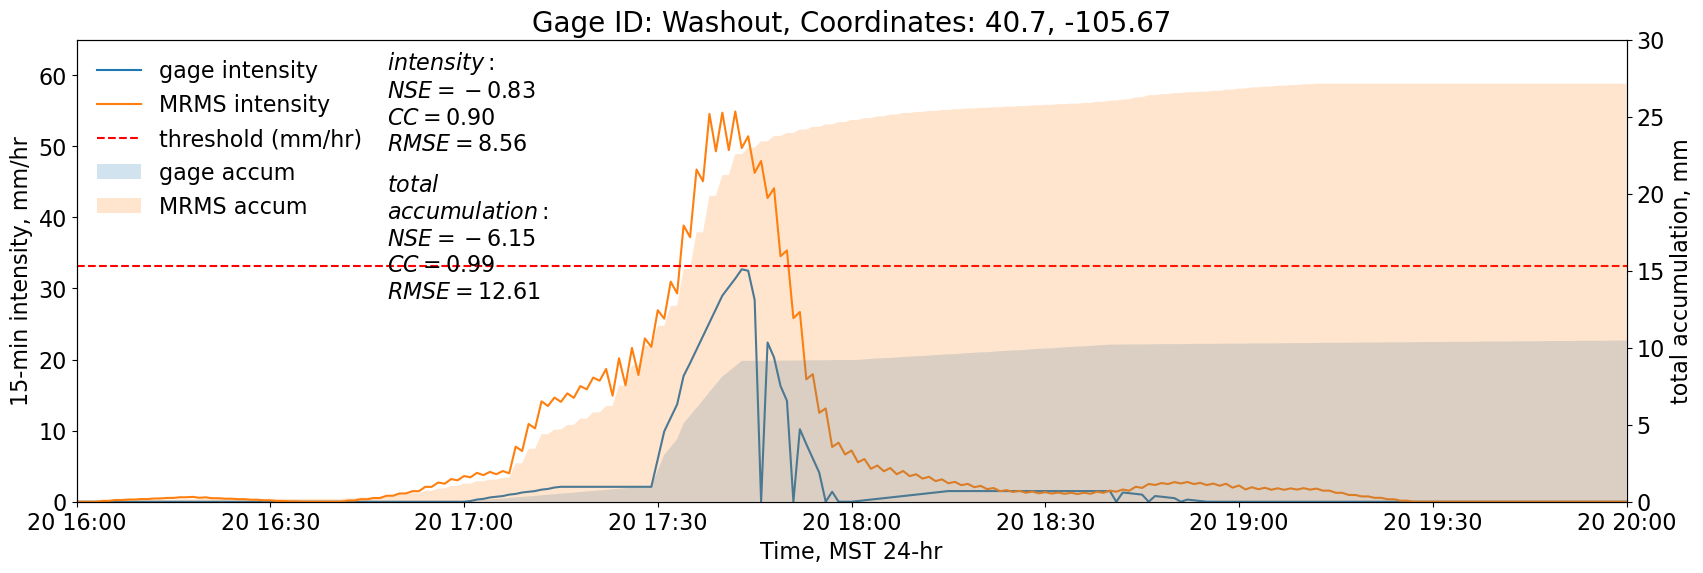

In [33]:
for i in range(len(gage_id)):
    coord = gage_coord[gage_id[i]]
    values = gage_values[gage_id[i]]['2021-07-20 16:00':'2021-07-20 20:00']
    name = gage_names[gage_id[i]]
    
    m_accum = mrms_2_corrected.sel(time = slice(values.index[0], values.index[-1]))
    m_accum = m_accum.sel(latitude = coord[0], longitude = coord[1], method='nearest')
    
    m_accum = m_accum.resample(time='1min').asfreq()
    m_accum = m_accum.unknown.fillna(0)
    m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)
    
    fig, ax1 = plt.subplots(1, figsize=(20,6))
    plt.xticks(fontsize=16)     
    ax1.tick_params(labelsize = 16)   

    ax2 = ax1.twinx()
    ax2.tick_params(labelsize = 16)
    ax1.plot(values.index,values['15_int'])
    ax1.plot(m_15.time,m_15)

    ax2.fill_between(values.index,values['accum'].cumsum(),alpha=.2)
    ax2.fill_between(m_accum.time,m_accum.cumsum(),alpha=.2)    

    threshold = 33.2
    x1 = values.index[0]
    x2 = values.index[-1]

    ax1.plot([x1,x2],[threshold,threshold],'r--')

    ax1.set_ylabel('15-min intensity, mm/hr',fontsize=16)
    ax2.set_ylabel('total accumulation, mm',fontsize=16)
    ax1.set_xlabel('Time, MST 24-hr',fontsize=16)

    plt.xlim(x1,x2)
    ax1.set_ylim(bottom=0,top=65)
    ax2.set_ylim(bottom=0,top=30)

    prediction = m_15.values
    target = values['15_int'].values
    nash1=nse(prediction,target)
    CC1=np.corrcoef(prediction,target)[0,1]
    rmse1 = np.sqrt(np.mean((prediction-target)**2))

    prediction2 = m_accum.cumsum().values
    target2 = values['accum'].cumsum().values
    nash2=nse(prediction2,target2)
    CC2=np.corrcoef(prediction2,target2)[0,1]
    rmse2 = np.sqrt(np.mean((prediction2-target2)**2))

    textstr1 = '\n'.join((
    r'$intensity:%.2f$' ,
    r'$NSE=%.2f$' % (nash1, ),
    r'$CC=%.2f$' % (CC1, ),
    r'$RMSE=%.2f$' % (rmse1, ),))

    textstr2 = '\n'.join((
    r'$total%.2f$' ,
    r'$accumulation:%.2f$' ,
    r'$NSE=%.2f$' % (nash2, ),
    r'$CC=%.2f$' % (CC2, ),
    r'$RMSE=%.2f$' % (rmse2, ),))

    #props = dict(boxstyle='round', alpha=0.5)
    plt.text(0.2, .98, textstr1, transform=ax1.transAxes,fontsize=16,verticalalignment='top')
    plt.text(0.2, .71, textstr2, transform=ax1.transAxes,fontsize=16,verticalalignment='top')

    ax1.legend(['gage intensity','MRMS intensity','threshold (mm/hr)'],fontsize=16,frameon=False,loc='upper left')
    ax2.legend(['gage accum','MRMS accum'],fontsize=16,frameon=False,loc='upper left', bbox_to_anchor=(0, 0.78))

    plt.title(name,fontsize=20)
    plt.show()

movie grizzly

In [26]:
coord = [i for i in grizzly.keys()]

In [103]:
grizzly_exploded=grizzly_basins.explode().reset_index().drop([1,2],axis=0).reset_index().to_crs(crs=plotcrs)

c:\temp\3\ipykernel_11216\1916902071.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  grizzly_exploded=grizzly_basins.explode().reset_index().drop([1,2],axis=0).reset_index().to_crs(crs=plotcrs)


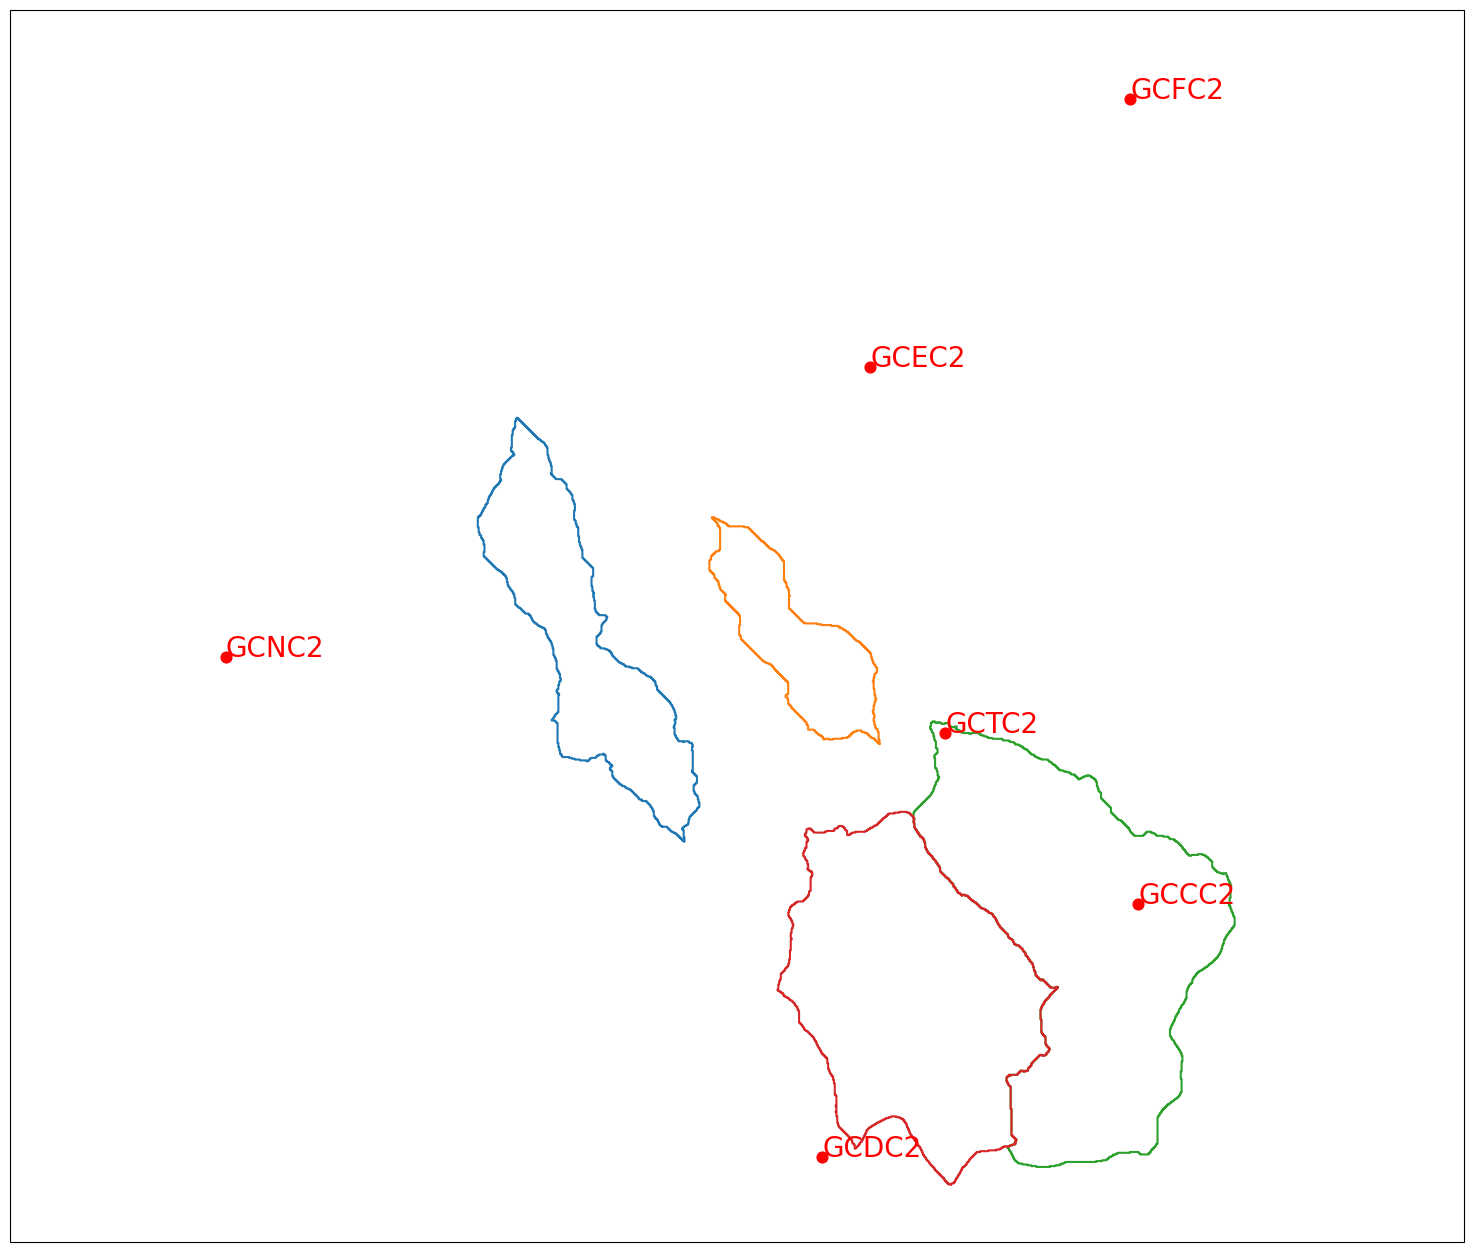

In [104]:
mrms = mrms_multi_21.unknown.where(mrms_multi_21.unknown>0)

lon, lat = np.meshgrid(mrms.longitude,mrms.latitude)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)
#ax.set_extent((252.3, 253.5, 39.2, 40)) # slightly larger area
ax.set_extent((252.685, 252.885, 39.535, 39.665)) # focus on gages

x = [i[1] for i in coord]
y = [i[0] for i in coord]
ax.scatter(x,y,s=60,c='r',transform=ccrs.PlateCarree())


for i in range(len(grizzly_exploded)):
    gx,gy=grizzly_exploded.geometry[i].exterior.xy
    ax.plot(gx,gy)

griz_id=['GCFC2', 'GCEC2', 'GCNC2', 'GCTC2', 'GCCC2', 'GCDC2']
for i in range(len(griz_id)):
    ax.text(x[i],y[i],griz_id[i],transform=ccrs.PlateCarree(), fontsize=20,color='r')

plt.rcParams['animation.html']='jshtml'
artists = []
ds = []

times = gage_values['GCFC2']['2021-07-29 18:00':'2021-07-30 00:00'].index
start = times[0]
end = times[-1]
mrms_storm = mrms.sel(time=slice(start,end))    

for i in range(len(mrms_storm)):
    ds = mrms_storm[i]
    #this_time = 'Storm_ID: '+str(storm_time.iloc[j]['storm_id'])+', Storm Date: '+str(mrms_storm[i].time.values)[0:10]+', Hour: '+str(mrms_storm[i].time.values)[11:16]
    #text = ax.text(0.5,1,this_time,ha='center',verticalalignment='bottom',transform=ax.transAxes, fontsize=20)
    mesh = ax.pcolormesh(lon,lat,ds,transform=ccrs.PlateCarree(),cmap='viridis', alpha=0.6,vmin=0,vmax=24)    
    artists.append([mesh])

anim = ArtistAnimation(fig, artists, interval = 200)
anim

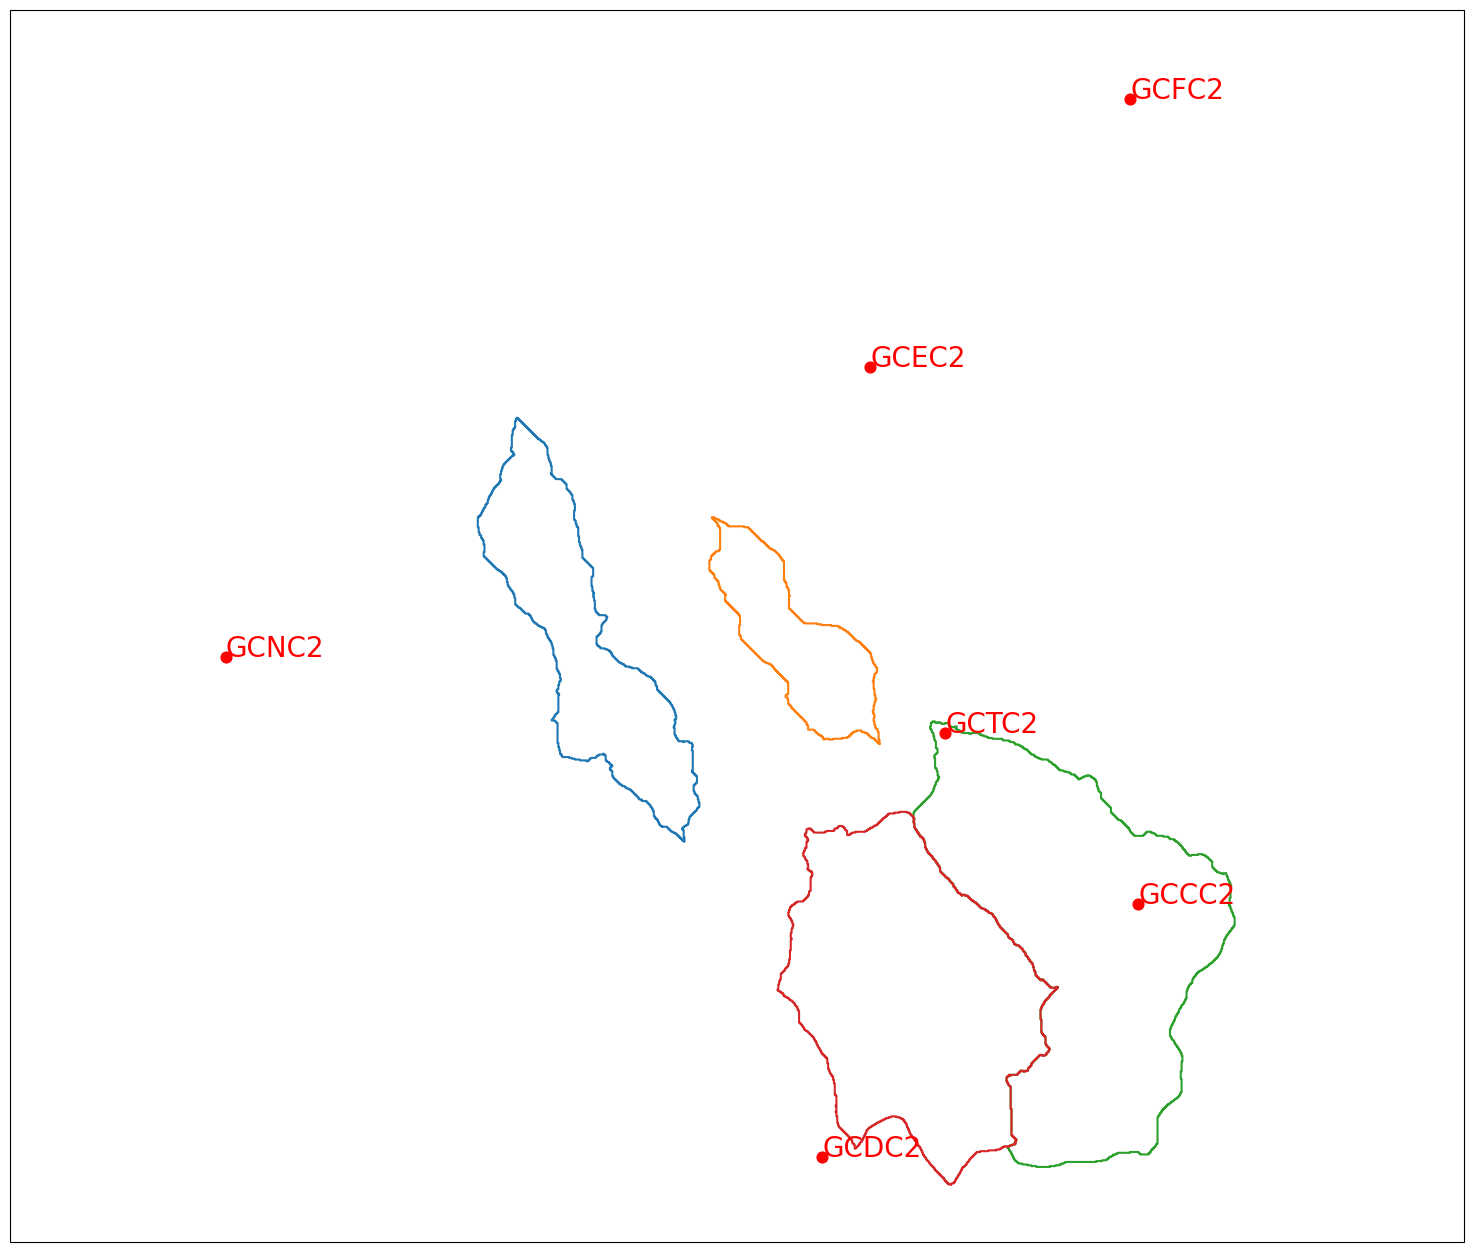

In [105]:
mrms = mrms_multi_21.unknown.where(mrms_multi_21.unknown>0)

lon, lat = np.meshgrid(mrms.longitude,mrms.latitude)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)
#ax.set_extent((252.3, 253.5, 39.2, 40)) # slightly larger area
ax.set_extent((252.685, 252.885, 39.535, 39.665)) # focus on gages

x = [i[1] for i in coord]
y = [i[0] for i in coord]
ax.scatter(x,y,s=60,c='r',transform=ccrs.PlateCarree())


for i in range(len(grizzly_exploded)):
    gx,gy=grizzly_exploded.geometry[i].exterior.xy
    ax.plot(gx,gy)

griz_id=['GCFC2', 'GCEC2', 'GCNC2', 'GCTC2', 'GCCC2', 'GCDC2']
for i in range(len(griz_id)):
    ax.text(x[i],y[i],griz_id[i],transform=ccrs.PlateCarree(), fontsize=20,color='r')

plt.rcParams['animation.html']='jshtml'
artists = []
ds = []

times = gage_values['GCFC2']['2021-07-31 15:00':'2021-07-31 20:00'].index
start = times[0]
end = times[-1]
mrms_storm = mrms.sel(time=slice(start,end))    

for i in range(len(mrms_storm)):
    ds = mrms_storm[i]
    #this_time = 'Storm_ID: '+str(storm_time.iloc[j]['storm_id'])+', Storm Date: '+str(mrms_storm[i].time.values)[0:10]+', Hour: '+str(mrms_storm[i].time.values)[11:16]
    #text = ax.text(0.5,1,this_time,ha='center',verticalalignment='bottom',transform=ax.transAxes, fontsize=20)
    mesh = ax.pcolormesh(lon,lat,ds,transform=ccrs.PlateCarree(),cmap='viridis', alpha=0.6,vmin=0,vmax=24)    
    artists.append([mesh])

anim = ArtistAnimation(fig, artists, interval = 200)
anim

move cpf

In [382]:
cpf_coords = [gage_coord[i] for i in ['dry','disdrom','washout']]

In [383]:
cpf_exploded=cpf_basins.explode().reset_index().drop([4],axis=0).reset_index().to_crs(crs=plotcrs)

c:\temp\3\ipykernel_11216\4087799848.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  cpf_exploded=cpf_basins.explode().reset_index().drop([4],axis=0).reset_index().to_crs(crs=plotcrs)


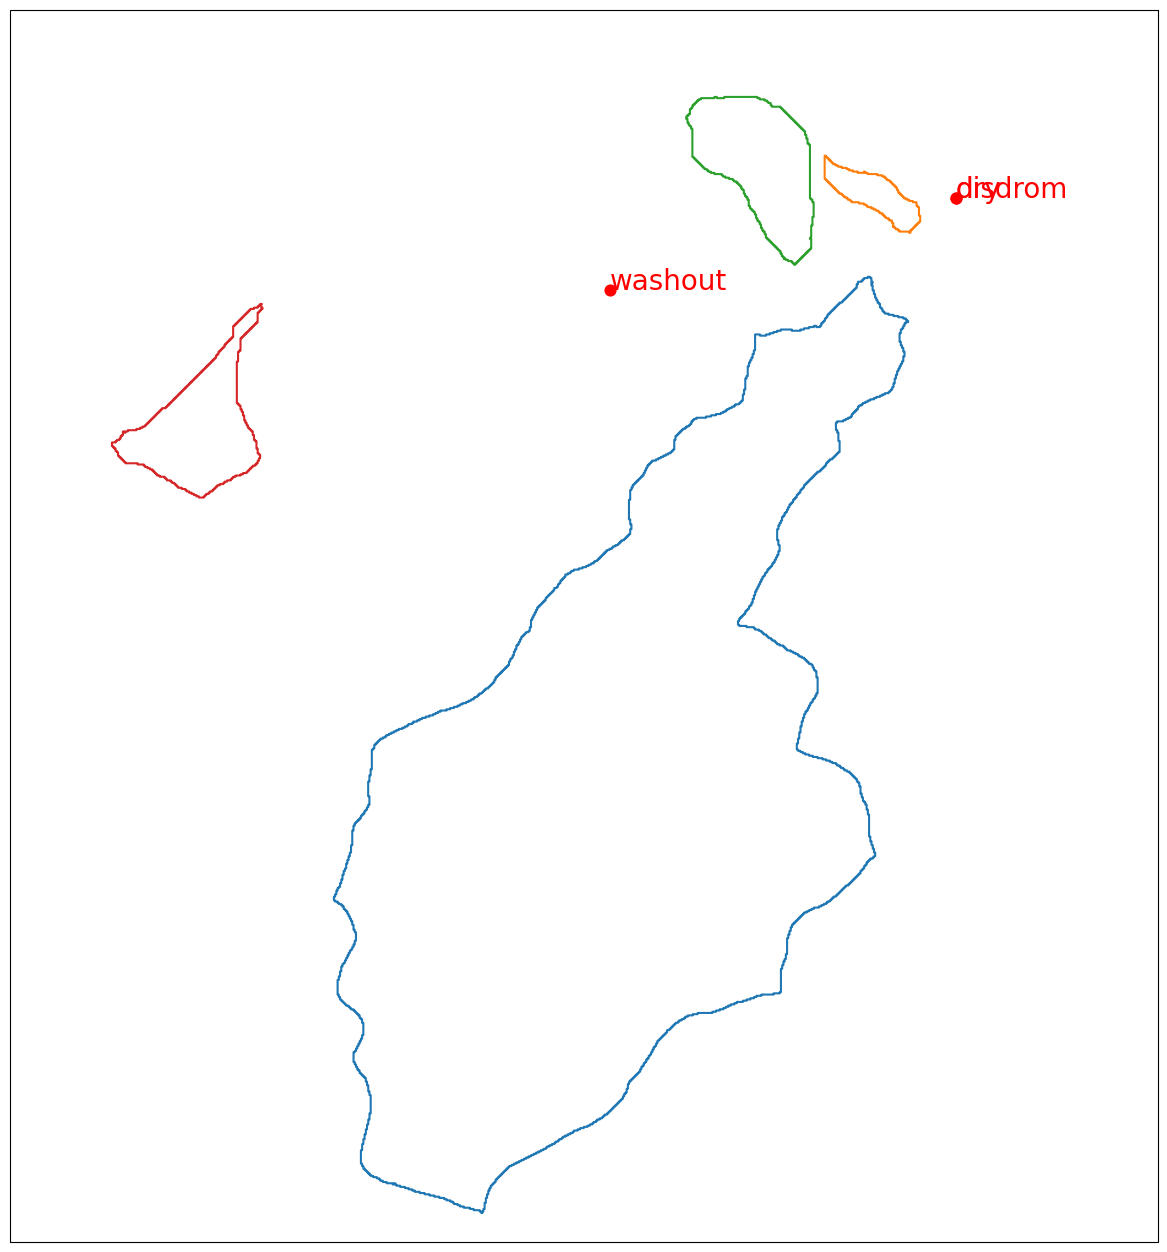

In [384]:
mrms = mrms_multi_21.unknown.where(mrms_multi_21.unknown>0)
#mrms = test.unknown.where(mrms_multi_21.unknown>0)
#mrms = temp.unknown
lon, lat = np.meshgrid(mrms.longitude,mrms.latitude)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)
#ax.set_extent((252.3, 253.5, 39.2, 40)) # slightly larger area
ax.set_extent((254.27, 254.38, 40.63, 40.72)) # focus on gages

x = [i[1] for i in cpf_coords]
y = [i[0] for i in cpf_coords]
ax.scatter(x,y,s=60,c='r',transform=ccrs.PlateCarree())


for i in range(len(cpf_exploded)):
    gx,gy=cpf_exploded.geometry[i].exterior.xy
    ax.plot(gx,gy)

griz_id=['dry','disdrom','washout']
for i in range(len(griz_id)):
    ax.text(x[i],y[i],griz_id[i],transform=ccrs.PlateCarree(), fontsize=20,color='r')

plt.rcParams['animation.html']='jshtml'
artists = []
ds = []

times = gage_values['disdrom']['2021-07-20 15:00':'2021-07-20 20:00'].index
start = times[0]
end = times[-1]
mrms_storm = mrms.sel(time=slice(start,end))    

for i in range(len(mrms_storm)):
    ds = mrms_storm[i]
    #this_time = 'Storm_ID: '+str(storm_time.iloc[j]['storm_id'])+', Storm Date: '+str(mrms_storm[i].time.values)[0:10]+', Hour: '+str(mrms_storm[i].time.values)[11:16]
    #text = ax.text(0.5,1,this_time,ha='center',verticalalignment='bottom',transform=ax.transAxes, fontsize=20)
    mesh = ax.pcolormesh(lon,lat,ds,transform=ccrs.PlateCarree(),cmap='viridis', alpha=0.6,vmin=0,vmax=24)    
    artists.append([mesh])

anim = ArtistAnimation(fig, artists, interval = 200)
anim

time above threshold heatmap

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


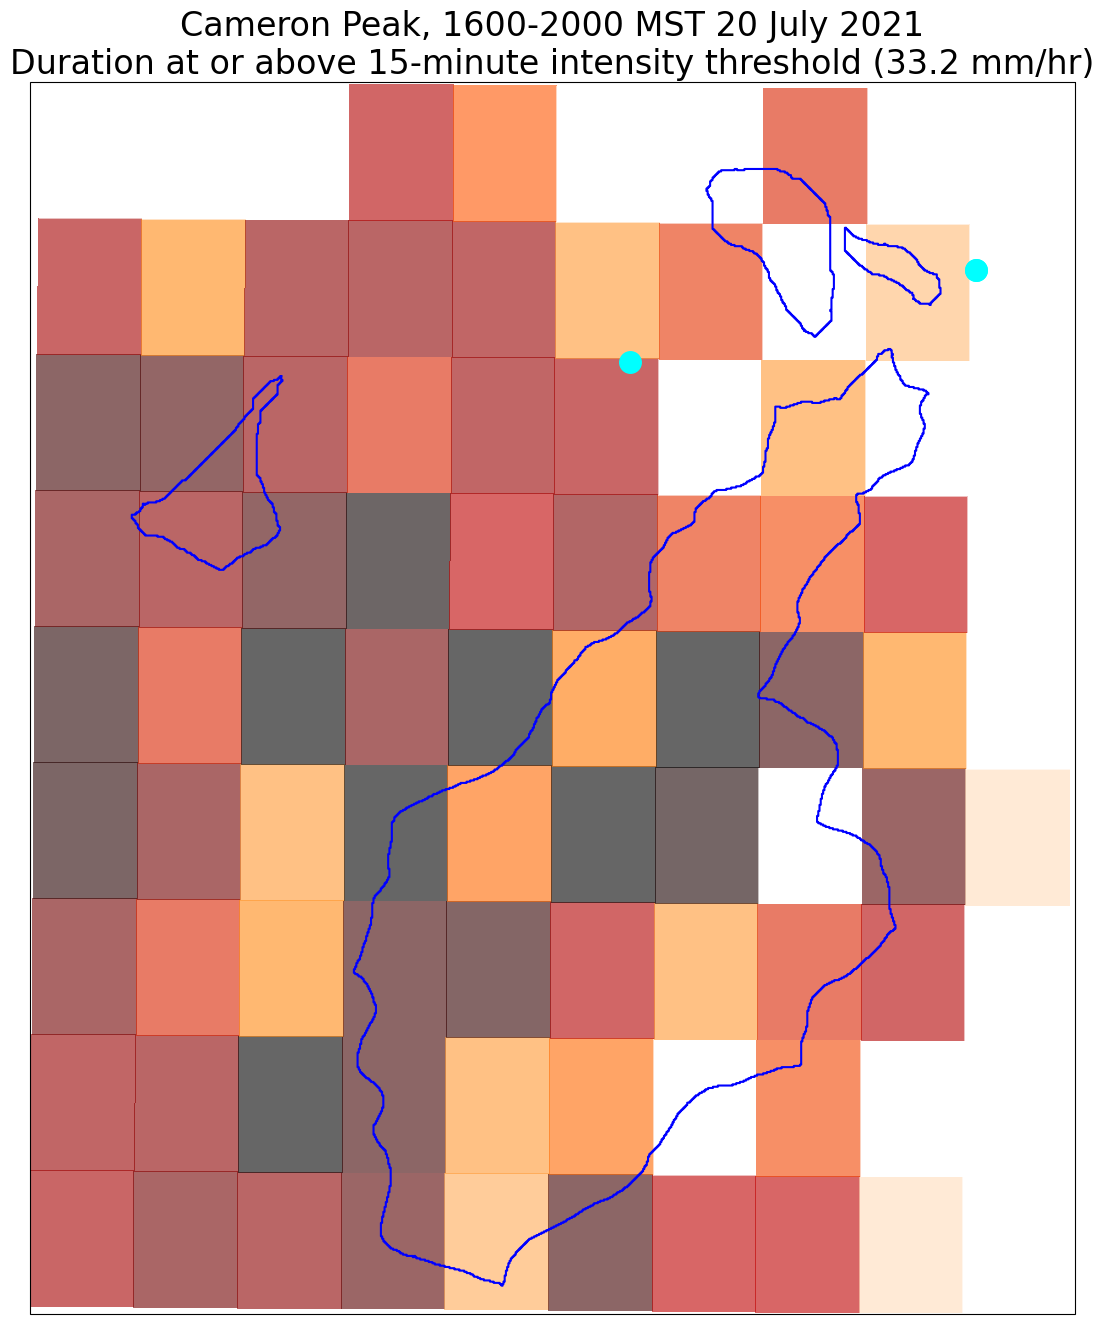

In [386]:
times = gage_values['disdrom']['2021-07-20 16:00':'2021-07-20 20:00'].index

m_accum = mrms_2_corrected.sel(time = slice(times[0], times[-1]))
m_accum = m_accum.sel(latitude = slice(40.63, 40.72), longitude = slice(254.27, 254.38))
m_accum = m_accum.resample(time='1min').asfreq()
m_accum = m_accum.unknown.fillna(0)
m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)

threshold = 33.2

m_15 = m_15.to_dataframe().reset_index()
above = m_15.loc[m_15.unknown>=threshold]
time_above = above.groupby(['latitude','longitude']).count()
time_above = time_above.to_xarray().time.fillna(0)

lon, lat = np.meshgrid(time_above.longitude,time_above.latitude)
 
fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)




plt.title('Cameron Peak, 1600-2000 MST 20 July 2021\nDuration at or above 15-minute intensity threshold (33.2 mm/hr)', fontsize=24)
mesh = ax.pcolormesh(lon,lat,time_above,transform=ccrs.PlateCarree(),cmap='gist_heat_r', alpha=0.6,vmin=0,vmax=30) 



x = [i[1] for i in cpf_coords]
y = [i[0] for i in cpf_coords]
ax.scatter(x,y,s=240,c='cyan',transform=ccrs.PlateCarree())

for i in range(len(cpf_exploded)):
    gx,gy=cpf_exploded.geometry[i].exterior.xy
    ax.plot(gx,gy,'blue')

In [387]:
gage_id = ['GCFC2','GCEC2','GCNC2','GCTC2','GCCC2','GCDC2']

In [388]:
grizzly_exploded=grizzly_basins.explode().reset_index().drop([1,2],axis=0).reset_index().to_crs(crs=plotcrs)

c:\temp\3\ipykernel_11216\1916902071.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  grizzly_exploded=grizzly_basins.explode().reset_index().drop([1,2],axis=0).reset_index().to_crs(crs=plotcrs)


In [389]:
coord = [i for i in grizzly.keys()]

In [ ]:
['2021-07-31 15:00':'2021-07-31 20:00']

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


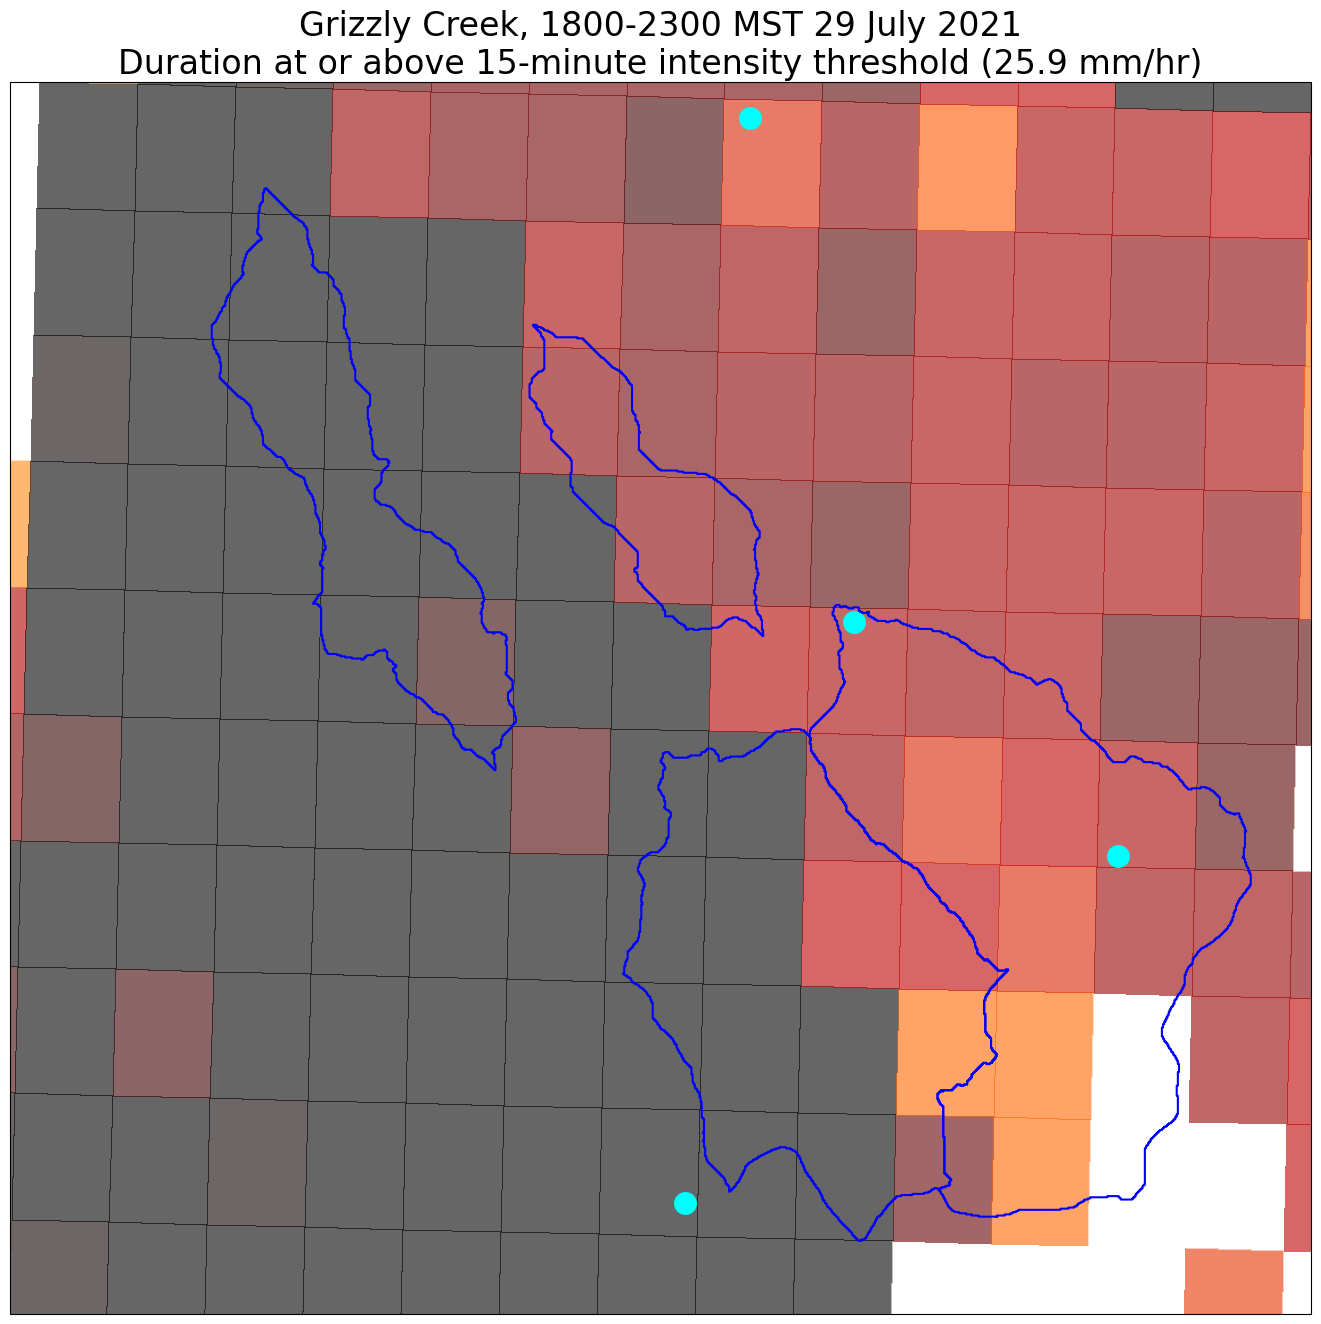

In [394]:
times = gage_values['GCFC2']['2021-07-29 18:00':'2021-07-29 23:00'].index

m_accum = mrms_2_corrected.sel(time = slice(times[0], times[-1]))
m_accum = m_accum.sel(latitude = slice(39.53, 39.665), longitude = slice(252.685, 252.885))
m_accum = m_accum.resample(time='1min').asfreq()
m_accum = m_accum.unknown.fillna(0)
m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)

threshold = 25.9

m_15 = m_15.to_dataframe().reset_index()
above = m_15.loc[m_15.unknown>=threshold]
time_above = above.groupby(['latitude','longitude']).count()
time_above = time_above.to_xarray().time.fillna(0)

lon, lat = np.meshgrid(time_above.longitude,time_above.latitude)
 
fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)

ax.set_extent((252.73, 252.86, 39.535, 39.63)) # focus on gages

plt.title('Grizzly Creek, 1800-2300 MST 29 July 2021\nDuration at or above 15-minute intensity threshold (25.9 mm/hr)', fontsize=24)
mesh = ax.pcolormesh(lon,lat,time_above,transform=ccrs.PlateCarree(),cmap='gist_heat_r', alpha=0.6,vmin=0,vmax=30) 
'''cb =fig.colorbar(mesh,orientation="horizontal", shrink=.5,pad=0.01)
cb.ax.tick_params(labelsize=16)
cb.set_label("Duration, min", fontsize=18)'''


x = [i[1] for i in coord]
y = [i[0] for i in coord]
ax.scatter(x,y,s=240,c='cyan',transform=ccrs.PlateCarree())

for i in range(len(grizzly_exploded)):
    gx,gy=grizzly_exploded.geometry[i].exterior.xy
    ax.plot(gx,gy,'blue')

C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\whitep\.conda\envs\radar\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


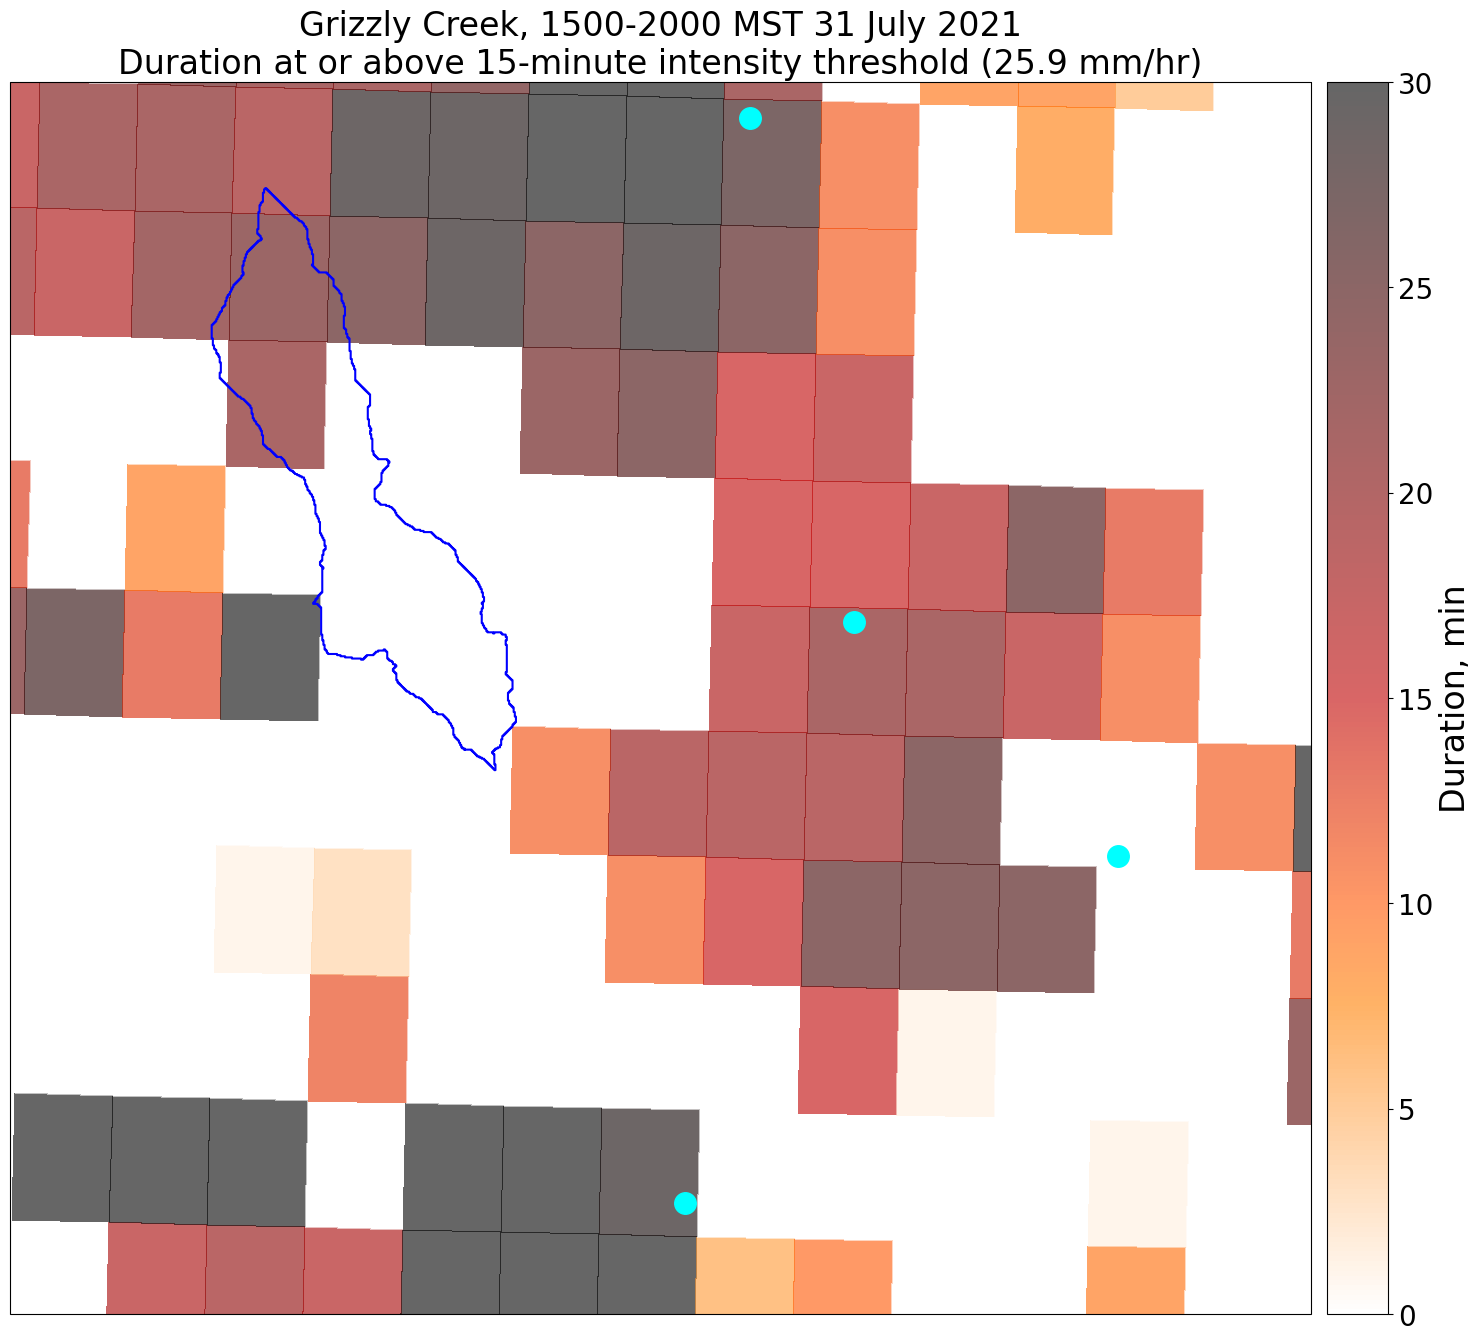

In [418]:
times = gage_values['GCFC2']['2021-07-31 15:00':'2021-07-31 20:00'].index

m_accum = mrms_2_corrected.sel(time = slice(times[0], times[-1]))
m_accum = m_accum.sel(latitude = slice(39.53, 39.665), longitude = slice(252.685, 252.885))
m_accum = m_accum.resample(time='1min').asfreq()
m_accum = m_accum.unknown.fillna(0)
m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)

threshold = 25.9

m_15 = m_15.to_dataframe().reset_index()
above = m_15.loc[m_15.unknown>=threshold]
time_above = above.groupby(['latitude','longitude']).count()
time_above = time_above.to_xarray().time.fillna(0)

lon, lat = np.meshgrid(time_above.longitude,time_above.latitude)
 
fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-105)
ax = plt.subplot(1,1,1, projection=plotcrs)

ax.set_extent((252.73, 252.86, 39.535, 39.63)) # focus on gages

plt.title('Grizzly Creek, 1500-2000 MST 31 July 2021\nDuration at or above 15-minute intensity threshold (25.9 mm/hr)', fontsize=24)
mesh = ax.pcolormesh(lon,lat,time_above,transform=ccrs.PlateCarree(),cmap='gist_heat_r', alpha=0.6,vmin=0,vmax=30) 
cb =fig.colorbar(mesh ,pad=0.01,ax=ax)
cb.ax.tick_params(labelsize=20)
cb.set_label("Duration, min", fontsize=24)


x = [i[1] for i in coord]
y = [i[0] for i in coord]
ax.scatter(x,y,s=240,c='cyan',transform=ccrs.PlateCarree())

gx,gy=grizzly_exploded.geometry[0].exterior.xy
ax.plot(gx,gy,'blue')

select basin
convert basin coords
select mrms around basin
calc 15min int
plot basin, gages, 15min int above threshold 

In [ ]:
gage_id = ['dry','disdrom','washout']

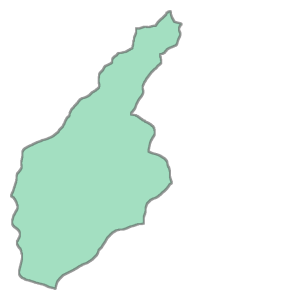

In [392]:
cpf_exploded.geometry[0]

In [286]:
# convert to mrms crs
cpf_exploded=cpf_exploded.to_crs(crs="EPSG:4326")

for i in range(len(cpf_exploded)):
    fig = plt.figure(1, figsize=(20,16))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

    values = gage_values[gage_id[i]]['2021-07-20 15:00':'2021-07-20 20:00']
    name = gage_names[gage_id[i]]
    
    gx,gy=cpf_exploded.geometry[1].exterior.xy
    ax.plot(gx,gy)
    gx = [i+360 for i in gx]
    temp =mrms_2_corrected.sel(latitude=gy, longitude=gx, method='nearest')
    lat_test = np.unique(temp.latitude.values)
    lon_test = np.unique(temp.longitude.values)
    temp =mrms_2_corrected.sel(latitude=lat_test, longitude=lon_test, method='nearest')
    
    m_accum = temp.sel(time = slice(values.index[0], values.index[-1]))
    
    m_accum = m_accum.resample(time='1min').asfreq()
    m_accum = m_accum.unknown.fillna(0)
    m_15 = (m_accum.rolling(time=15,min_periods=1).sum())*(60/15)
    
    x = [i[1] for i in cpf_coords]
    y = [i[0] for i in cpf_coords]
    ax.scatter(x,y,s=60,c='r',transform=ccrs.PlateCarree())
    

In [287]:
lon_test = [i+360 for i in gx]

In [288]:
temp =mrms_multi_21.sel(latitude=gy, longitude=lon_test, method='nearest')

In [282]:
lat_test = np.unique(temp.latitude.values)

In [283]:
lon_test = np.unique(temp.longitude.values)

In [284]:
test =mrms_multi_21.sel(latitude=lat_test, longitude=lon_test, method='nearest')

In [289]:
temp

<xarray.Dataset>
Dimensions:         (time: 8745, latitude: 186, longitude: 186)
Coordinates:
  * time            (time) datetime64[ns] 2020-12-31T17:00:00 ... 2021-12-31T...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 40.7 40.7 40.7 40.7 ... 40.7 40.7 40.7
  * longitude       (longitude) float64 254.4 254.4 254.4 ... 254.4 254.4 254.4
    valid_time      (time) datetime64[ns] dask.array<chunksize=(8745,), meta=np.ndarray>
Data variables:
    unknown         (time, latitude, longitude) float32 dask.array<chunksize=(44, 186, 186), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2022-11-28T08:36 GRIB to CDM+CF via cfgrib-0.9.1...

In [314]:
stacked = cpf_rate.unknown.stack(coord=("longitude", "latitude"))

In [352]:
x = [stacked.coord.values[i][0]-360 for i in range(len(stacked.coord))]

In [327]:
y = [stacked.coord.values[i][1] for i in range(len(stacked.coord))]

In [353]:
points = gpd.GeoSeries.from_xy(x,y, crs="EPSG:4326")

In [309]:
cpf_basins['convert']=cpf_basins['geometry'].to_crs(crs="EPSG:4326")

In [422]:
test = [points.within(cpf_basins.convert.envelope[i]) for i in cpf_basins.index]

In [428]:
truth_index=[]
for i in cpf_basins.index:
    truth_index.append([i for i, x in enumerate(test[i]) if x]) 

In [138]:
gage_values['disdrom']['2021-07-20 15:00':'2021-07-20 20:00'].index

DatetimeIndex(['2021-07-20 15:00:00', '2021-07-20 15:01:00',
               '2021-07-20 15:02:00', '2021-07-20 15:03:00',
               '2021-07-20 15:04:00', '2021-07-20 15:05:00',
               '2021-07-20 15:06:00', '2021-07-20 15:07:00',
               '2021-07-20 15:08:00', '2021-07-20 15:09:00',
               ...
               '2021-07-20 19:51:00', '2021-07-20 19:52:00',
               '2021-07-20 19:53:00', '2021-07-20 19:54:00',
               '2021-07-20 19:55:00', '2021-07-20 19:56:00',
               '2021-07-20 19:57:00', '2021-07-20 19:58:00',
               '2021-07-20 19:59:00', '2021-07-20 20:00:00'],
              dtype='datetime64[ns]', name='datetime', length=301, freq='T')

[]

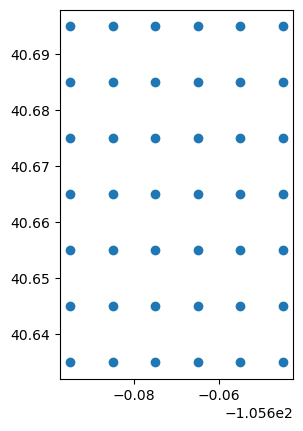

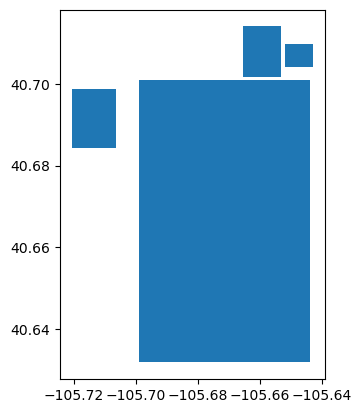

In [433]:

t = points.iloc[truth_index[0]].plot()

base = cpf_basins.convert.envelope.plot()

t.plot(ax=base)

In [ ]:
cpf_basins

In [385]:
test = points.within(cpf_basins.convert[0])

In [389]:
t=test[test].index

create fig of study area

In [18]:
# open elevation
elev = '\\CO_SRTM1arcsec__merge.tif'
folder = parentDir
elev = folder+elev
codtm = rxr.open_rasterio(elev)
# change lon to match global lat/lon in grib file
codtm = codtm.assign_coords(x=(((codtm.x + 360))))
codtm = codtm.rename({'x':'longitude','y':'latitude'})
codtm = codtm.sel(band=1)

In [ ]:
# gages, basins, elevation, roads?

In [ ]:
# cpf


In [ ]:
# grizzly

create timeseries compare for accum and 15min with stats

In [ ]:
# select mrms 1 gage at a time, find storms
target = []
predict = []

for i in range(len(coord)):
    print('gagecount='+str(i))
    # get corresponding mrms coordinate
    latt = lat[i]
    lont = lon[i]
    # select mrms at coordinate
    m_g = m.sel(longitude=lont,latitude=latt,drop=True)
    # convert to pandas dataframe, speeds things up
    m_g = m_g.to_dataframe()
    
    # calculate 15-min intensity
    mrms_one = m_g.resample('1min').asfreq()
    mrms_one.unknown = mrms_one.unknown.fillna(0)
    mrms_one.unknown = (mrms_one.unknown.rolling(15,min_periods=1).sum())*(60/15) 
    # resampling goes through nonexistant months, reselect times
    mrms_15_21 = mrms_one['2021-04-30 20:16':'2021-09-30 17:00']
    mrms_15_22 = mrms_one['2022-04-30 20:16':'2022-09-30 17:00']
    mrms_15 = pd.concat([mrms_15_21,mrms_15_22],axis=0)
    
    # get gage
    g = gage[coord[i]]
    # fix gage timer issues
    shift = s[i]
    g.index = g.index+shift
    # caculating 15-min intensity caused weird rounding issues, fix by setting to zero
    g.loc[g['15_int']<0.0001] = 0
    # select gage data within mrms times, if gage outside mrms
    g = g.loc[g.index.isin(mrms_15.index)]
    g['gage']=i
    
    # select mrms times within gage times, if mrms outside gage
    mrms_15 = mrms_15.loc[mrms_15.index.isin(g.index)]
    mrms_15['gage']=i
    
    # sample gage and mrms 
    target.append(g.resample('8h').agg(list))
    predict.append(mrms_15.resample('8h').agg(list))
    
target = pd.concat(target)
predict = pd.concat(predict)

d = {'mrms':predict.unknown,'gage':target['15_int'],'storm_id':predict.storm_id,'gage_id':predict.gage}
compare = pd.DataFrame(data=d)

compare.storm_id = [np.unique(compare.storm_id[i]) for i in range(len(compare))]
compare.gage_id = [np.unique(compare.gage_id[i]) for i in range(len(compare))]